

## <p style="background-color:white;font-family:newtimeroman;color:coral;font-size:230%;text-align:center;border-radius:20px 60px;">Sales Prediction for Chain of Stores - WALMART</p>

![](https://appinventiv.com/wp-content/uploads/sites/1/2019/09/Walmart%E2%80%99s-Journey-in-the-Blockchain-Arena-1.png)


#### Predicting future sales for a company is one of the most important aspects of strategic planning. 

In this kernel, we will wanted analyze in depth how internal and external factors of one of the biggest companies in the US can affect their Weekly Sales in the future. 

*This module contains complete analysis of data , includes time series analysis , identifies the best performing stores , performs sales prediction with the help of multiple linear regression.*

The data collected ranges from 2010 to 2012, where 45 Walmart stores across the country were included in this analysis. It is important to note that we also have external data available like CPI, Unemployment Rate and Fuel Prices in the region of each store which, hopefully, help us to make a more detailed analysis.

## <p style="background-color:white;font-family:newtimeroman;color:coral;font-size:170%;text-align:center;border-radius:20px 60px;">Let's dive in . . .</p>



### <p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Introduction</p> 
 
 #### In Retail Industry and chain of stores one of the biggest issue they face are supply chain management. The component of supply chain management (SCM) involved with determining how best to fulfill the requirements created from the Demand Plan. 
 
 *It's objective is to balance supply and demand in a manner that achieves the financial and service objectives of the enterprise.*
 
  If we look into the case of a retail chain stores one of the basic case is to know the demand of products that are sold in the store. If the decision making authority know whats the demand of each products for a week or month, they would be able to plan the supply chain accordingly. If that is possible this would save a lot of money for them because they don't have to overstock or can plan their Logistics accordingly.
   
![](https://miro.medium.com/max/600/1*ixQ_TdPP3RmPQcPUzSVCrA.jpeg)

 
### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Data</p> 

### There are 3 Datasets :

#### Stores:
- Store: The store number. Range from 1–45.
- Type: Three types of stores ‘A’, ‘B’ or ‘C’.
- Size: Sets the size of a Store would be calculated by the no. of products available in the particular store ranging from 34,000 to 210,000.

***primary key is Store***

#### Sales:
    -Date: The date of the week where this observation was taken.
    -Weekly_Sales: The sales recorded during that Week.
    -Store: The store which observation in recorded 1–45
    -Dept: One of 1–99 that shows the department.
    -IsHoliday: Boolean value representing a holiday week or not.

***primary key is a combination of (Store,Dept,Date).***

#### Features:

    -Temperature: Temperature of the region during that week.
    -Fuel_Price: Fuel Price in that region during that week.
    -MarkDown1:5 : Represents the Type of markdown and what quantity was available during that week.
    -CPI: Consumer Price Index during that week.
    -Unemployment: The unemployment rate during that week in the region of the store.

***primary key here is a combination of (Store,Date)***

![](https://i.imgur.com/XuDXqGU.png)


### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Plan of Action</p> 

    1. We will perform dertailed EDA & Time series analysis and gather useful insights
    2. Next we will build the following Regression models to predict future sales.


 **List of Models -**
 
     1. Lasso Regressor
     2. Random Forest Regressor
     3. Gradient Boosting Regressor
     4. Support Vector Regressor
     5. Time Series Analysis
 


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Dataset Importing and Querying</p>

    We will load all 3 datasets and merge them  into one big dataset that gives whole data. 

### Note :

*Since here we are only predicting Store level sales we will group the dataframes such that Department level data gets eliminated and take the sum of department level sales to give the store level sales.*

In [1]:
# Importing all necessary libraries to proceed with this project.

import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta


ss = StandardScaler()



In [2]:
pwd

'/kaggle/working'

In [3]:
cd ../input/walmart-recruiting-store-sales-forecasting

/kaggle/input/walmart-recruiting-store-sales-forecasting


In [4]:
pwd

'/kaggle/input/walmart-recruiting-store-sales-forecasting'

#### Load and read data

In [5]:
walmart = pd.read_csv('train.csv.zip')

walmart_feature = pd.read_csv('features.csv.zip')

walmart_store = pd.read_csv('stores.csv')


In [6]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
walmart.shape

(421570, 5)



### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Group by Store</p> 

#### Since we are am predicting the weekly sales for Store level, we will grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [8]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)


**Merging all the datasets into one place for easier test and analysis.**

In [9]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)


In [10]:
print(data.shape)

(6435, 15)


**Dataframe Walmart with 421570 rows has come down to 6435 rows by doing a group by and merge** 




# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Data Cleaning</p>

<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Now let's look through the data and do some basic data cleaning</p> 


In [11]:

data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
#let's encode the categorical column : IsHoliday

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)
# Will convert the bool to 1 and 0 for easier use later.
#data.IsHoliday=data.IsHoliday.map(lambda x: 1 if x==True else 0)


In [13]:
# Want to check the date column is in object format or datetime
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [14]:
# yes my assumption was correct python have something to do with date format. 
# Now converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [15]:
# Lets look into the null values
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

**Wow!! Now that's huge. More Than 65% of value are missing in MarkDown values**

*We can impute sum values as of now for the missing  and will later decide  whether to use Markdown for modeling or should take some other approach for imputing or whether to discard MarkDowns completely*


In [16]:
#will create this column for later use
#data['MarkdownsSum'] = data['MarkDown1'] + data['MarkDown2'] + data['MarkDown3'] + data['MarkDown4'] + data['MarkDown5'] 

In [17]:
#data.fillna(0, inplace = True)

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Size,6435.0,1.302876e+05,63117.022465,34875.000,70713.000,126512.000000,2.023070e+05,2.196220e+05
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
MarkDown1,2280.0,6.855587e+03,8183.310015,0.270,1679.190,4972.590000,8.873583e+03,8.864676e+04
MarkDown2,1637.0,3.218966e+03,9268.082387,-265.760,37.200,187.040000,1.785290e+03,1.045195e+05
MarkDown3,2046.0,1.349853e+03,9287.242800,-29.100,4.700,22.700000,9.998750e+01,1.416306e+05
MarkDown4,1965.0,3.303858e+03,6211.203947,0.220,483.270,1419.420000,3.496080e+03,6.747485e+04
MarkDown5,2295.0,4.435262e+03,5868.933325,135.160,1702.565,3186.520000,5.422080e+03,1.085193e+05


In [19]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week 

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">EDA</p>
![](https://visme.co/blog/wp-content/uploads/2016/04/Header-5.gif)

In [20]:
data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Store,6435.000000,23.000000,12.988182,1.000000,12.000000,23.000000,34.000000,45.000000
Weekly_Sales,6435.000000,1046964.877562,564366.622054,209986.250000,553350.105000,960746.040000,1420158.660000,3818686.450000
Size,6435.000000,130287.600000,63117.022465,34875.000000,70713.000000,126512.000000,202307.000000,219622.000000
Temperature,6435.000000,60.663782,18.444933,-2.060000,47.460000,62.670000,74.940000,100.140000
Fuel_Price,6435.000000,3.358607,0.459020,2.472000,2.933000,3.445000,3.735000,4.468000
MarkDown1,2280.000000,6855.587430,8183.310015,0.270000,1679.190000,4972.590000,8873.582500,88646.760000
MarkDown2,1637.000000,3218.965504,9268.082387,-265.760000,37.200000,187.040000,1785.290000,104519.540000
MarkDown3,2046.000000,1349.853021,9287.242800,-29.100000,4.700000,22.700000,99.987500,141630.610000
MarkDown4,1965.000000,3303.858142,6211.203947,0.220000,483.270000,1419.420000,3496.080000,67474.850000
MarkDown5,2295.000000,4435.262240,5868.933325,135.160000,1702.565000,3186.520000,5422.080000,108519.280000


In [21]:
df_weeks = data.groupby('Week').sum()

import plotly.express as px
fig = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, title = 'Sales over weeks')
fig.update_traces(line_color='deeppink', line_width=3)

In [22]:
df_weeks.head()

,Store,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Year
Week,,,,,,,,,,,,,,,
1,2070,8.773121e+07,11725884,3438.27,287.489,214551.50,956964.10,5105.11,44069.57,223036.75,15421.135275,710.979,0,585,181035
2,2070,8.269676e+07,11725884,3167.09,291.404,148560.51,420168.49,3172.06,22332.89,165721.27,15430.151991,710.979,0,1215,181035
3,2070,8.273564e+07,11725884,3476.88,293.341,104001.81,141268.63,3098.39,27717.05,122143.56,15443.190027,710.979,0,1845,181035
4,2070,7.943483e+07,11725884,3455.57,294.581,63331.86,74200.84,3089.75,4254.13,116290.60,15456.228061,710.979,0,2475,181035
5,3105,1.419895e+08,17588826,4919.52,418.696,1624211.71,126542.47,6408.63,1286593.08,267767.25,23017.155918,1098.848,0,540,271485


In [23]:
import plotly.graph_objs as go
from plotly import tools

fig = go.Figure()

#fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )

fig.update_layout(title = 'Sales vs Markdown', xaxis_title = 'Weeks')

In [24]:
## setting all missing values in markdown columns to -500 for now. We will treat them later while performing Feature scaling
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

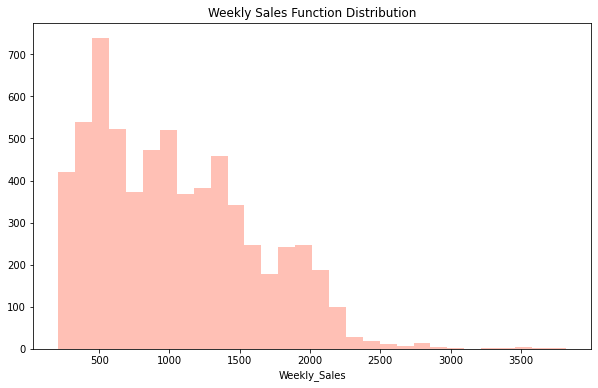

In [25]:
# From the Describe function we see that weekly sales for each store are very high. 
# we will scale down the value for ease of use and revert back when we look residuals or where necessary

plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()



In the Distribution, natural Log of Sales and the square root of Sales look better distributed. We can use Natural Log for predictions later


In [26]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

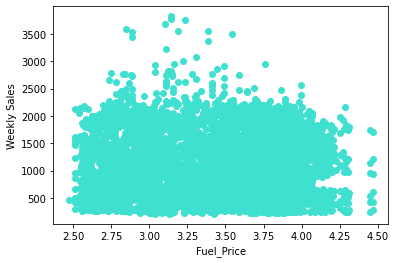

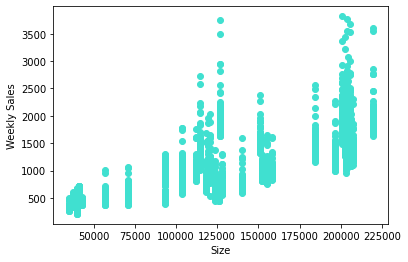

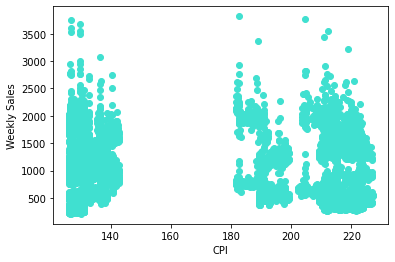

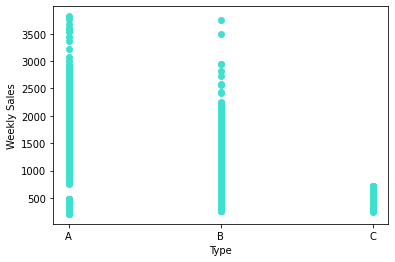

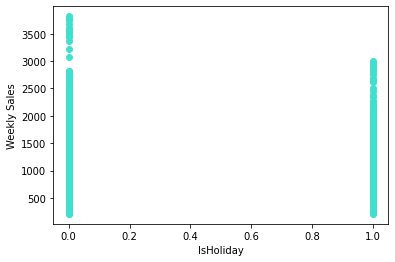

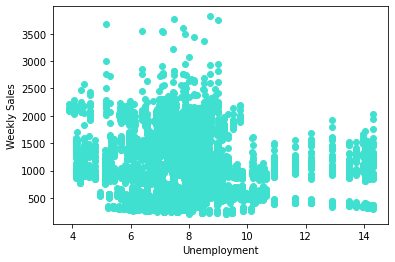

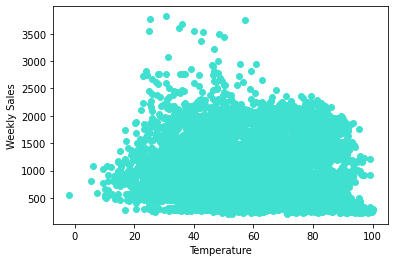

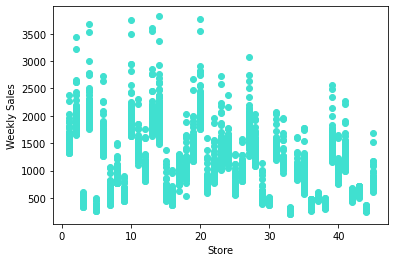

In [27]:
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')


In [28]:
data['Week'] = data.Date.dt.isocalendar().week 

In [29]:
data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Month,Year,Week
0,1,2010-02-05,1643.69090,A,151315,42.31,2.572,-500.0,-500.0,-500.0,-500.0,-500.0,211.096358,8.106,0,5,Feb,2010,5
1,1,2010-02-12,1641.95744,A,151315,38.51,2.548,-500.0,-500.0,-500.0,-500.0,-500.0,211.242170,8.106,1,12,Feb,2010,6
2,1,2010-02-19,1611.96817,A,151315,39.93,2.514,-500.0,-500.0,-500.0,-500.0,-500.0,211.289143,8.106,0,19,Feb,2010,7
3,1,2010-02-26,1409.72759,A,151315,46.63,2.561,-500.0,-500.0,-500.0,-500.0,-500.0,211.319643,8.106,0,26,Feb,2010,8
4,1,2010-03-05,1554.80668,A,151315,46.50,2.625,-500.0,-500.0,-500.0,-500.0,-500.0,211.350143,8.106,0,5,Mar,2010,9


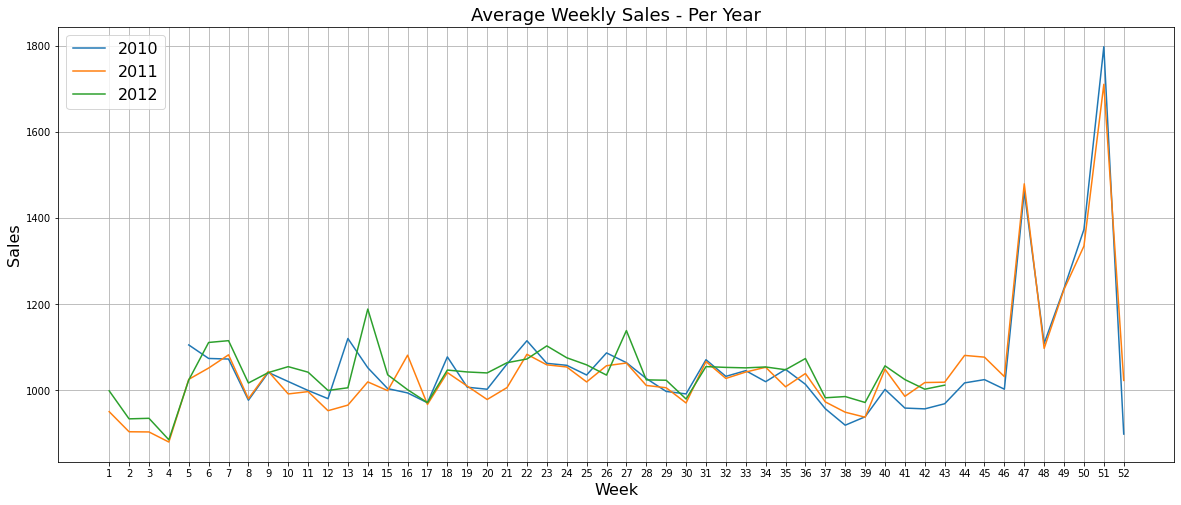

In [30]:
weekly_sales_2010 = data[data.Year==2010]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2011 = data[data.Year==2011]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2012 = data[data.Year==2012]['Weekly_Sales'].groupby(data['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


#### Note :

**As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.**

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012

Week 13 in 2013 for **Test set**

**So, we can change to 'True' these Weeks in each Year.**

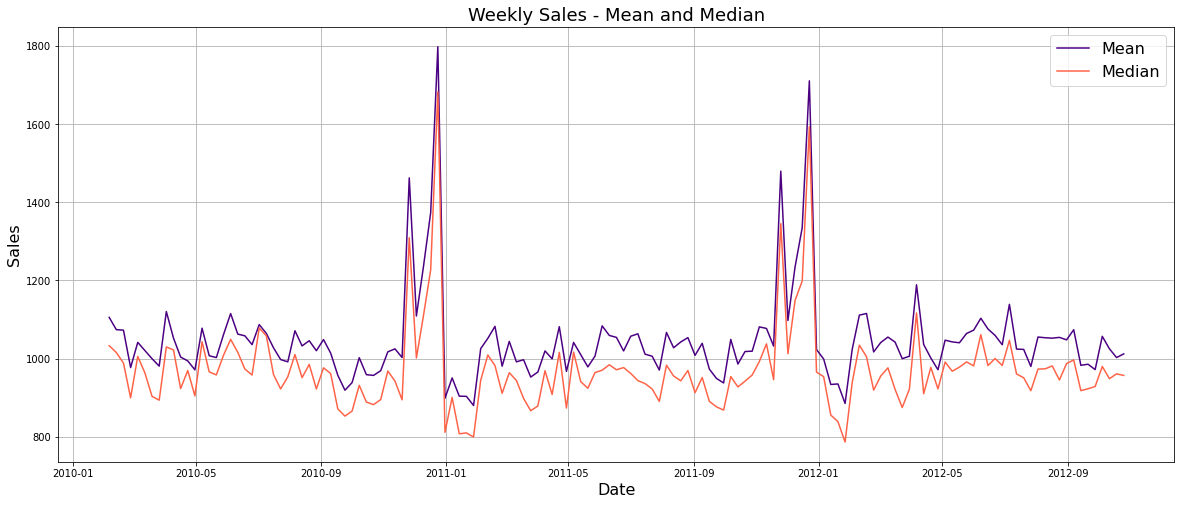

In [31]:
weekly_sales_mean = data['Weekly_Sales'].groupby(data['Date']).mean()
weekly_sales_median = data['Weekly_Sales'].groupby(data['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values, color = 'indigo')
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values, color = 'tomato')
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()


<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Checking the relationship of the other features with weekly sales</p> 

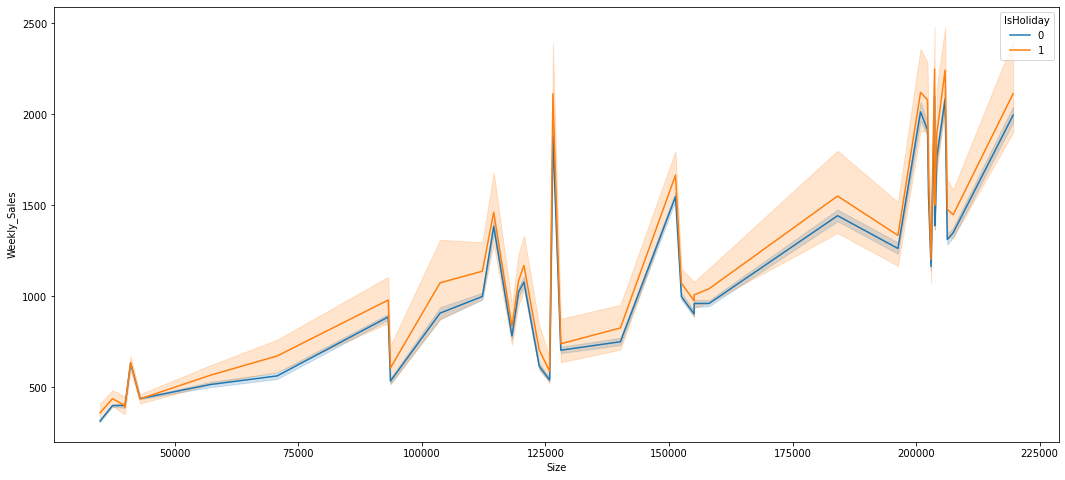

In [32]:
plt.figure(figsize=(18,8))
sns.lineplot ( data = data, x = 'Size', y =  'Weekly_Sales', hue = 'IsHoliday');

In [33]:
px.histogram(data, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [34]:
px.histogram(data, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [35]:
px.histogram(data, x='CPI', y ='Weekly_Sales', color='IsHoliday')

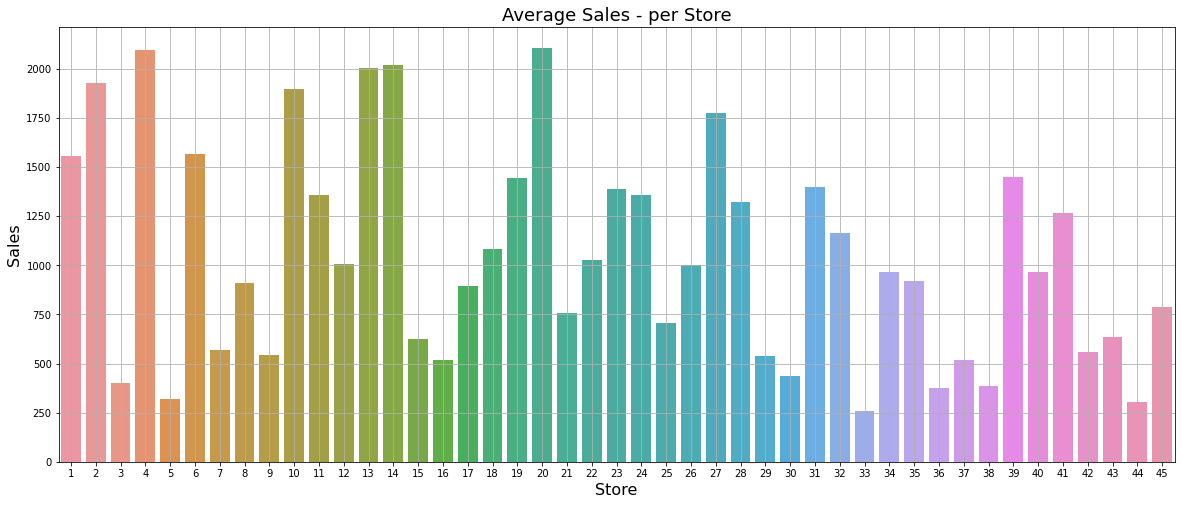

In [36]:
weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20,8))
plt.style.use('default')
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

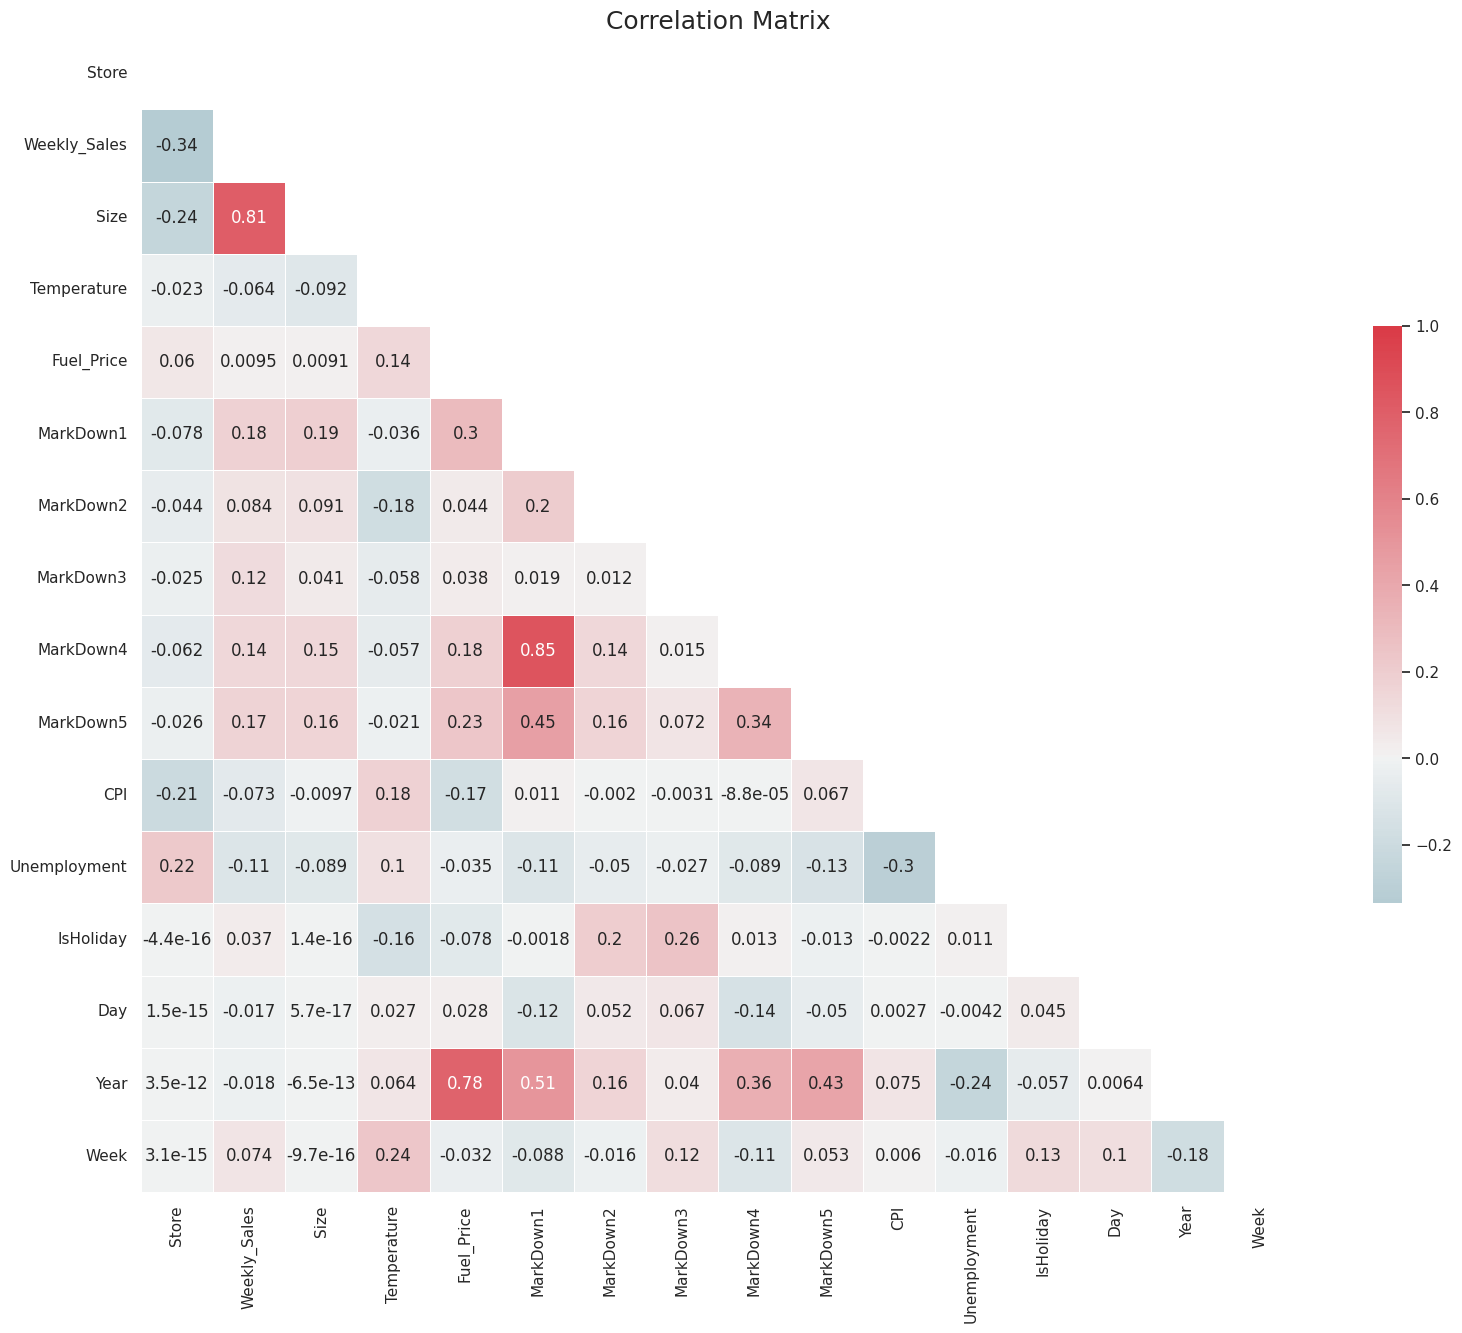

In [37]:
sns.set(style="white")

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Detailed Time-Series Analysis</p>

![](https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/69aa52fb-b692-463f-84c1-cde2470445ae/css-animation-craziness.gif)
![](https://windenergyscience.com/wp-content/uploads/2020/02/Data.gif)



<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> What is Time Series</p> 

Any data recorded with some fixed interval of time is called as time series data. This fixed interval can be hourly, daily, monthly or yearly. e.g. hourly temp reading, daily changing fuel prices, monthly electricity bill, annul company profit report etc. In time series data, time will always be independent variable and there can be one or many dependent variable. 

Sales forecasting time series with shampoo sales for every month will look like this, 

![Shampoo_Sales](https://raw.githubusercontent.com/satishgunjal/images/master/Shampoo_Sales.png)

In above example since there is only one variable dependent on time so its called as univariate time series. If there are multiple dependent variables, then its called as multivariate time series.

Objective of time series analysis is to understand how change in time affect the dependent variables and accordingly predict values for future time intervals.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Stationarity Data</p> 

For accurate analysis and forecasting trend and seasonality is removed from the time series and converted it into stationary series.
Time series data is said to be stationary when statistical properties like mean, standard deviation are constant and there is no seasonality. In other words statistical properties of the time series data should not be a function of time.

![Stationarity](https://raw.githubusercontent.com/satishgunjal/images/master/Stationarity.png)

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Test for Stationarity</p>

Easy way is to look at the plot and look for any obvious trend or seasonality. While working on real world data we can also use more sophisticated methods like rolling statistic and Augmented Dickey Fuller test to check stationarity of the data. 

### Rolling Statistics <a id ="11"></a>
In rolling statistics technique we define a size of window to calculate the mean and standard deviation throughout the series. For stationary series mean and standard deviation shouldn't change with time.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Augmented Dickey Fuller (ADF) Test</p>

I won't go into the details of how this test works. I will concentrate more on how to interpret the result of this test to determine the stationarity of the series. ADF test will return 'p-value' and 'Test Statistics' output values.
* **p-value > 0.05**: non-stationary.
* **p-value <= 0.05**: stationary.
* **Test statistics**: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series


![](https://i.pinimg.com/originals/cc/fe/1f/ccfe1f7fee5fe18a65127d4ed1f4c036.gif)


### We will consider one of the stores and perform a detailed time-series analysis on it

### Store 4

In [38]:
data1 = pd.read_csv('train.csv.zip')
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)



### Store 6

In [39]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

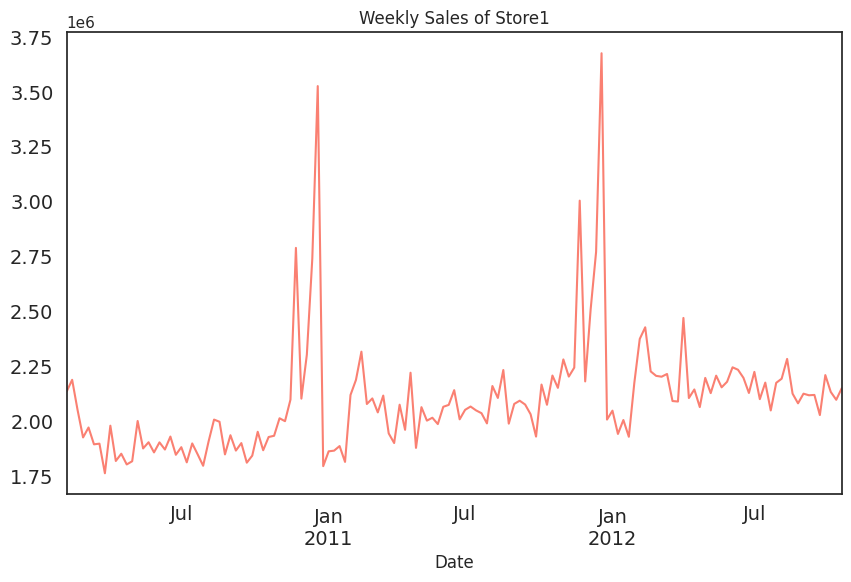

In [40]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store1', fontsize=14, color = 'salmon')
plt.show()

# <p style="background-color:white;font-family:newtimeroman;color:coral;font-size:150%;text-align:center;border-radius:20px 60px;">Time Series Components</p>


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Time Series Characteristics</p>

Mean, standard deviation and seasonality defines different characteristics of the time series. 

![Time_Series_Characteristics](https://raw.githubusercontent.com/satishgunjal/images/master/Time_Series_Characteristics.png)

Important characteristics of the time series are as below

### Trend <a id ="3"></a>
Trend represent the change in dependent variables with respect to time from start to end. In case of increasing trend dependent variable will increase with time and vice versa. It's not necessary to have definite trend in time series, we can have a single time series with increasing and decreasing trend. In short trend represent the varying mean of time series data.

![Trend](https://raw.githubusercontent.com/satishgunjal/images/master/Trend.png)

### Seasonality <a id ="4"></a>
If observations repeats after fixed time interval then they are referred as seasonal observations. These seasonal changes in data can occur because of natural events or man-made events. For example every year warm cloths sales increases just before winter season. So seasonality represent the data variations at fixed intervals.

![Seasonality](https://raw.githubusercontent.com/satishgunjal/images/master/Seasonality.png)

### Irregularities <a id ="5"></a>
This is also called as noise. Strange dips and jump in the data are called as irregularities. These fluctuations are caused by uncontrollable events like earthquakes, wars, flood, pandemic etc. For example because of COVID-19 pandemic there is huge demand for hand sanitizers and masks.

![Irregularities](https://raw.githubusercontent.com/satishgunjal/images/master/Irregularities.png)

### Cyclicity <a id ="6"></a>
Cyclicity occurs when observations in the series repeats in random pattern. Note that if there is any fixed pattern then it becomes seasonality, in case of cyclicity observations may repeat after a week, months or may be after a year. These kinds of patterns are much harder to predict.

![Cyclicity](https://raw.githubusercontent.com/satishgunjal/images/master/Cyclicity.png)

Time series data which has above characteristics is called as 'Non-Stationary Data'. For any analysis on time series data we must convert it to 'Stationary Data'

The general guideline is to estimate the trend and seasonality in the time series, and then make the time series stationary for data modeling. In data modeling step statistical techniques are used for time series analysis and forecasting. Once we have the predictions, in the final step forecasted values converted into the original scale by applying trend and seasonality constraints back.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Time Series Analysis</p>
As name suggest its analysis of the time series data to identify the patterns in it. I will briefly explain the different techniques and test for time series data analysis.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Time Series Decomposition</p>
Time series decomposition helps to deconstruct the time series into several component like trend and seasonality for better visualization of its characteristics. Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data

![Decomposition_of_Time_Series](https://raw.githubusercontent.com/satishgunjal/images/master/Decomposition_of_Time_Series.png)

### Additive Decomposition

* An additive model suggests that the components are added together.
* An additive model is linear where changes over time are consistently made by the same amount.
* A linear seasonality has the same frequency (width of the cycles) and amplitude (height of the cycles).

The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). You need to specify whether the model is additive or multiplicative.

The seasonal_decompose() function returns a result object which contains arrays to access four pieces of data from the decomposition.

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


<Figure size 640x480 with 0 Axes>

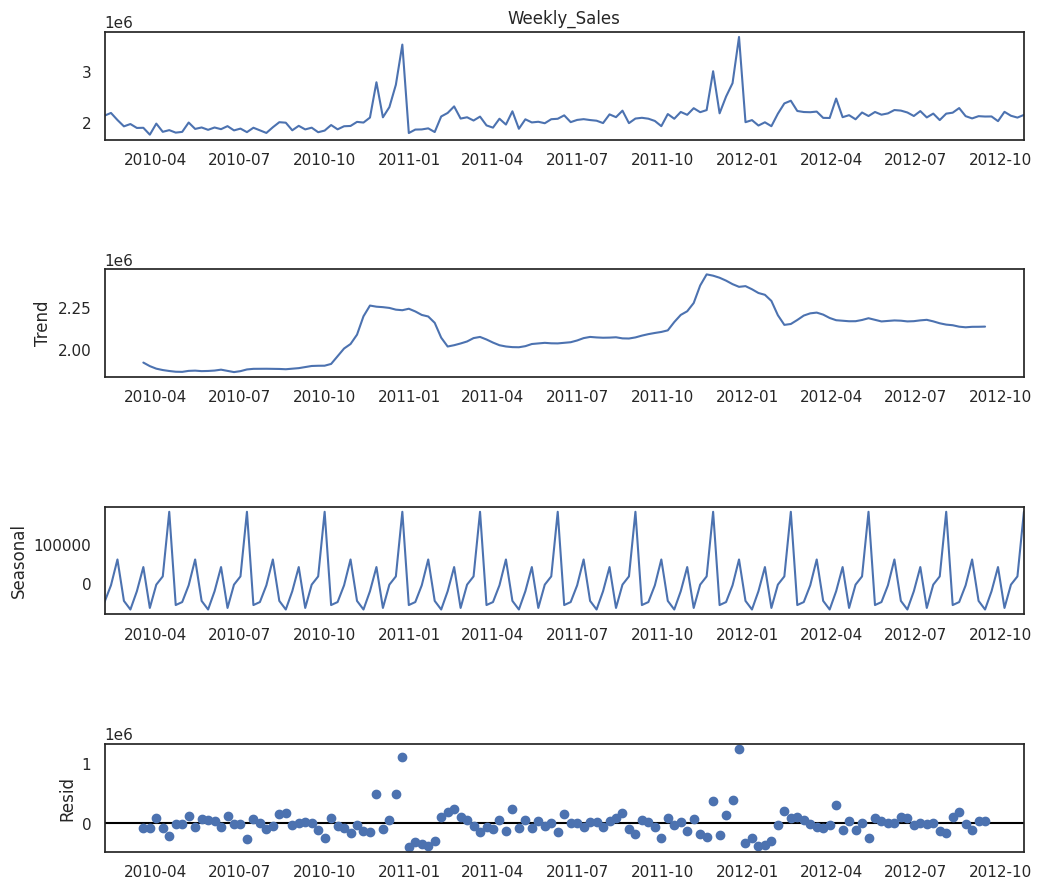

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()



### Multiplicative Decomposition

* An additive model suggests that the components are multipled together.
* An additive model is non-linear such as quadratic or exponential. 
* Changes increase or decrease over time.
* A non-linear seasonality has an increasing or decreasing frequency (width of the cycles) and / or amplitude (height of the cycles) over time.

<Figure size 640x480 with 0 Axes>

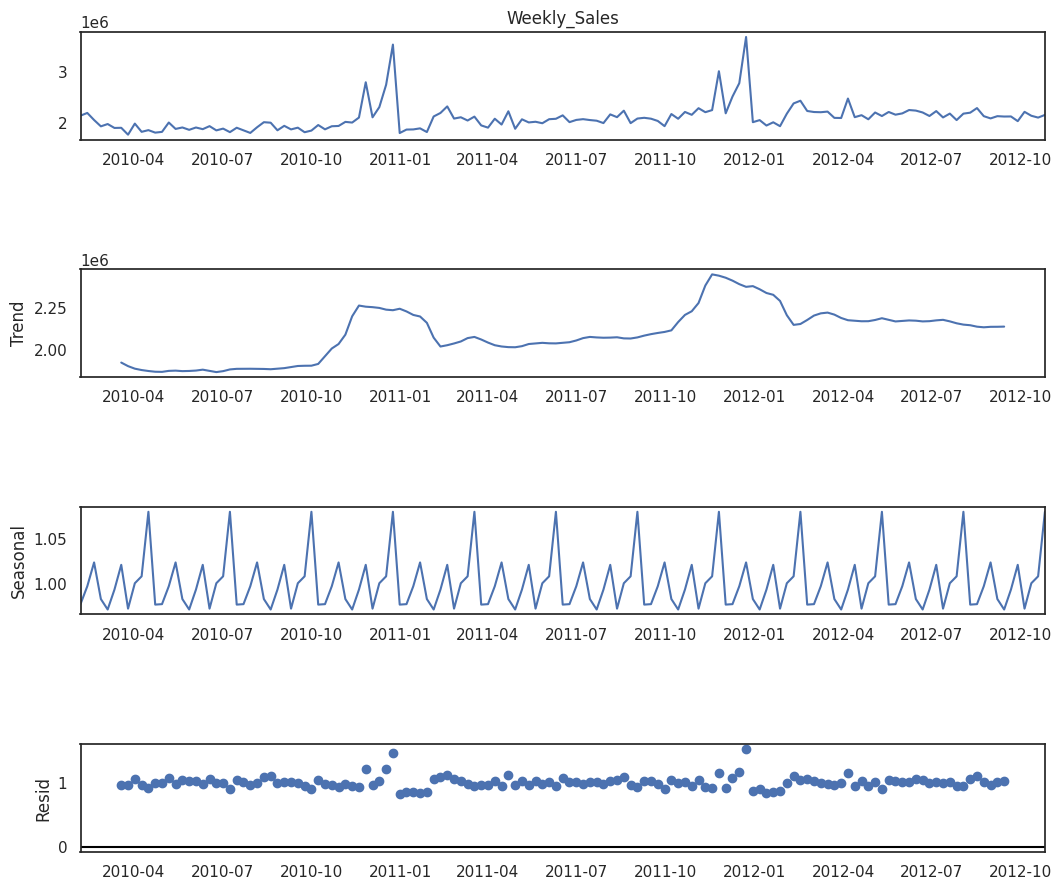

In [42]:
decomposition = seasonal_decompose(sales4.Weekly_Sales, model= 'multiplicative', period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [43]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

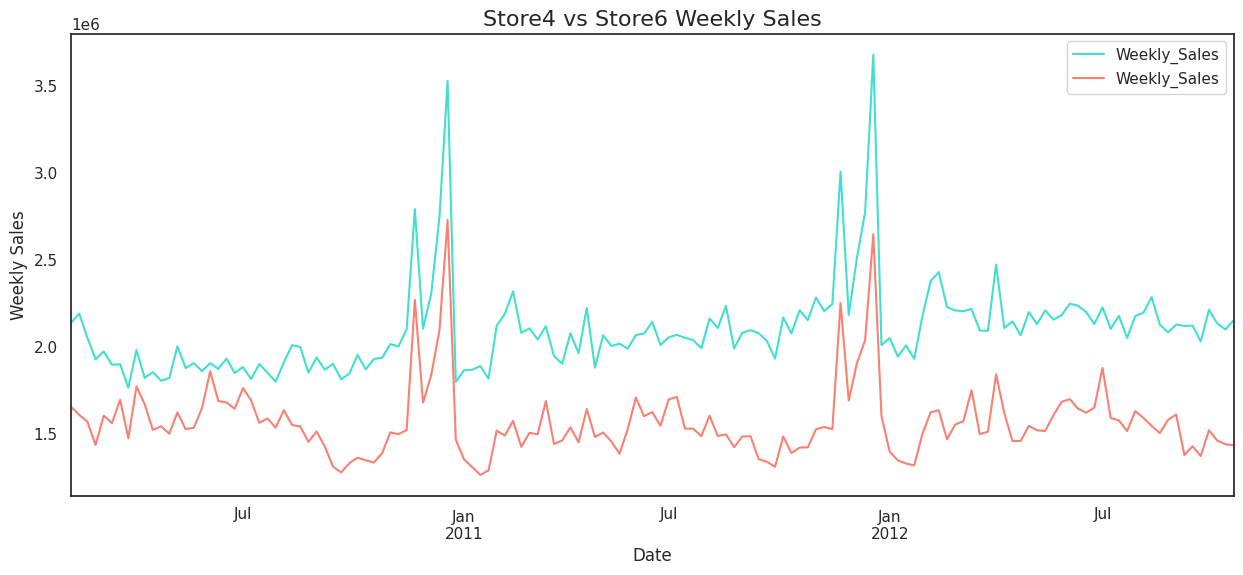

In [44]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

#### This shows an interesting trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude is different. 
    This clearly tells its a timeseries problem and it will be interesting to look more into it

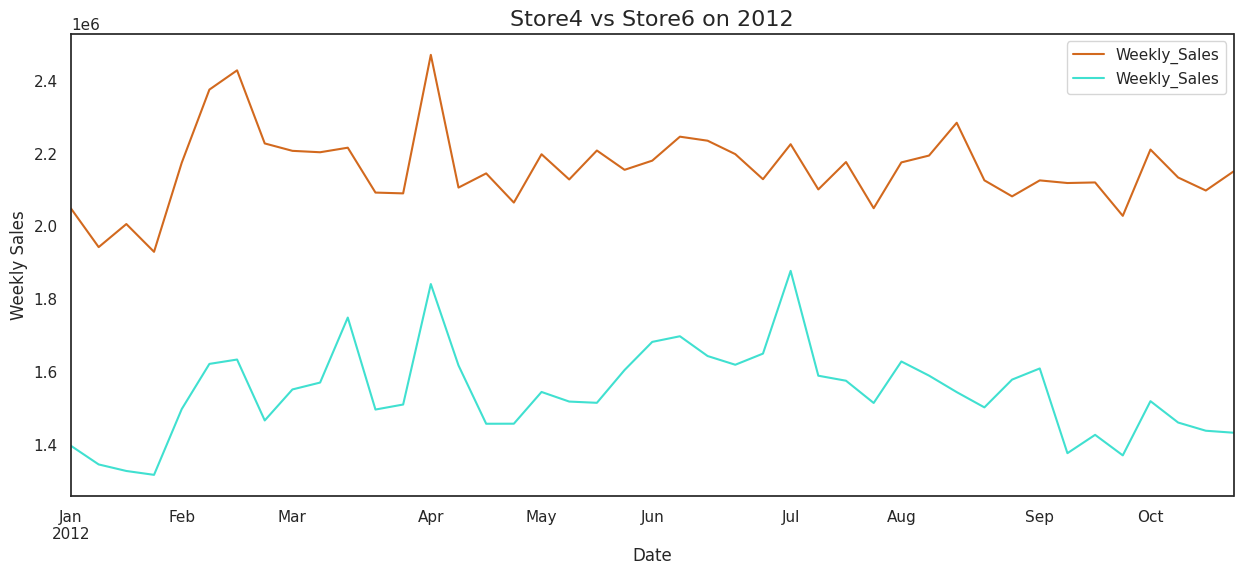

In [45]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

#### Not quite a trend. Here comes yet another component of timeseries - Irregular component

    which are other non random sources of variations of series and are mainly the impact of random events such as strikes, earthquakes, and sudden changes in the weather. By their nature, these effects are completely unpredictable.

In [46]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]


In [47]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32190D+00    |proj g|=  2.11788D-01


 This problem is unconstrained.



At iterate    5    f=  8.19196D+00    |proj g|=  3.64631D-01

At iterate   10    f=  8.03865D+00    |proj g|=  1.09208D+00

At iterate   15    f=  7.98422D+00    |proj g|=  3.19766D-01

At iterate   20    f=  7.98333D+00    |proj g|=  9.54899D-02

At iterate   25    f=  7.98300D+00    |proj g|=  5.19279D-02

At iterate   30    f=  7.98251D+00    |proj g|=  2.84406D-01

At iterate   35    f=  7.98218D+00    |proj g|=  4.34615D-02

At iterate   40    f=  7.98218D+00    |proj g|=  7.86771D-03

At iterate   45    f=  7.98215D+00    |proj g|=  5.57781D-02


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  7.98204D+00    |proj g|=  1.87909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.879D-02   7.982D+00
  F =   7.9820362802171276     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7482      0.541     -3.230      0.001      -2.809      -0.687
ar.L2         -1.2860      0.585     -2.200      0.028      -2.432      -0.140
ar.L3         -0.5939      0.252     -2.357  

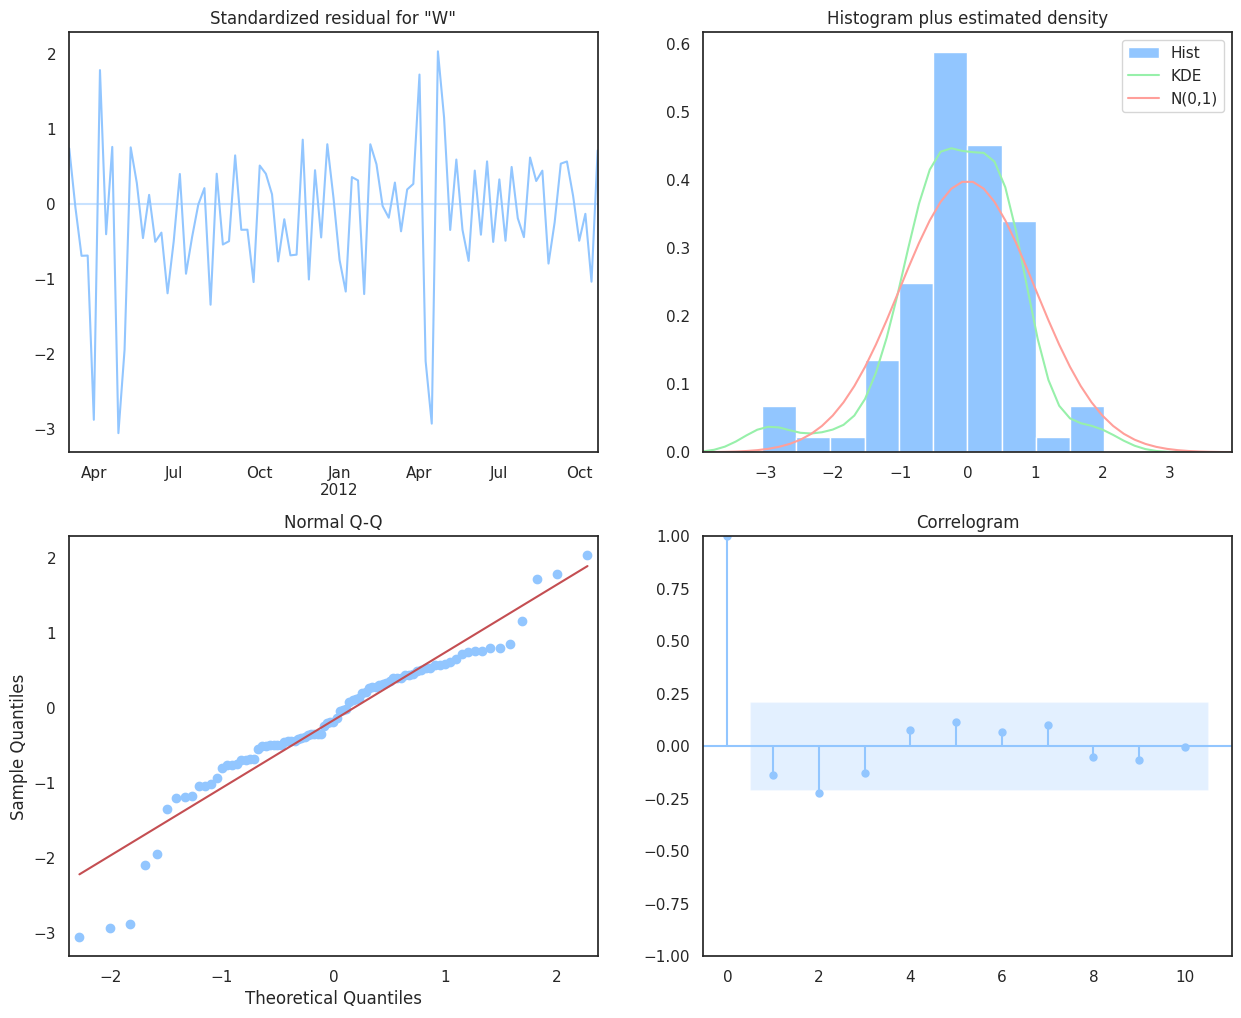

In [48]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [49]:
# Will predict for last 90 days. So setting the date according to that
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

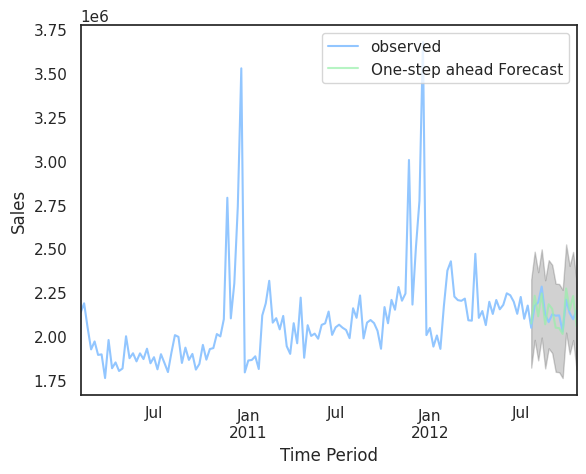

In [50]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [51]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4744734996.33


In [52]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

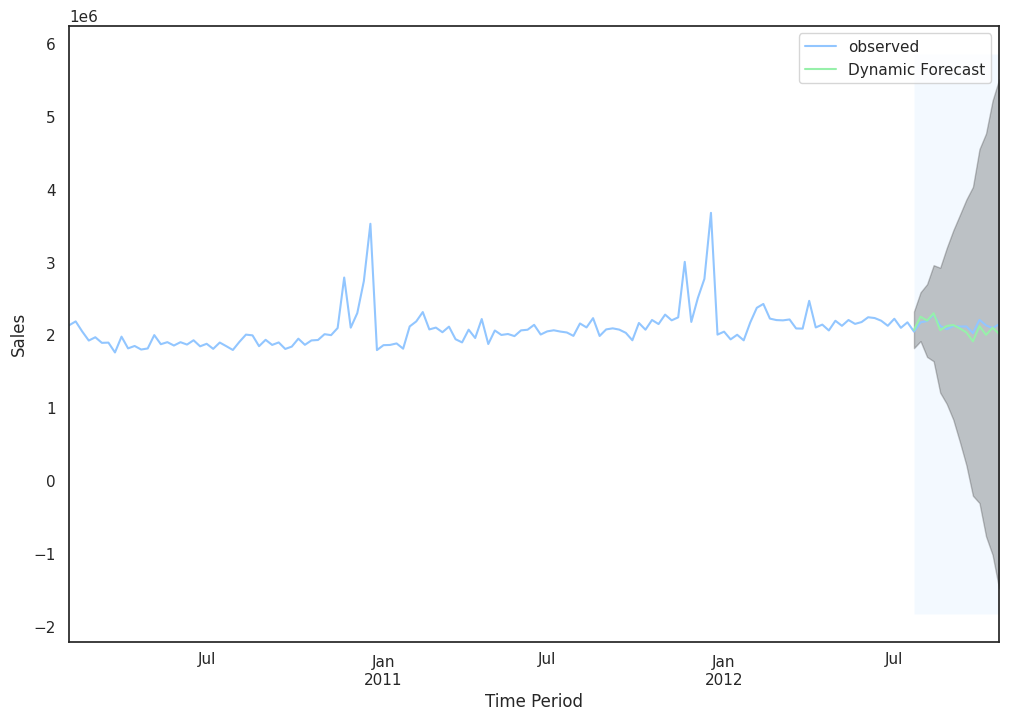

In [53]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### That looks good. Both the observed and predicted lines go together indicating nearly accurate prediction

In [54]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 72768.25


In [55]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 812868.5392511382


In [56]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

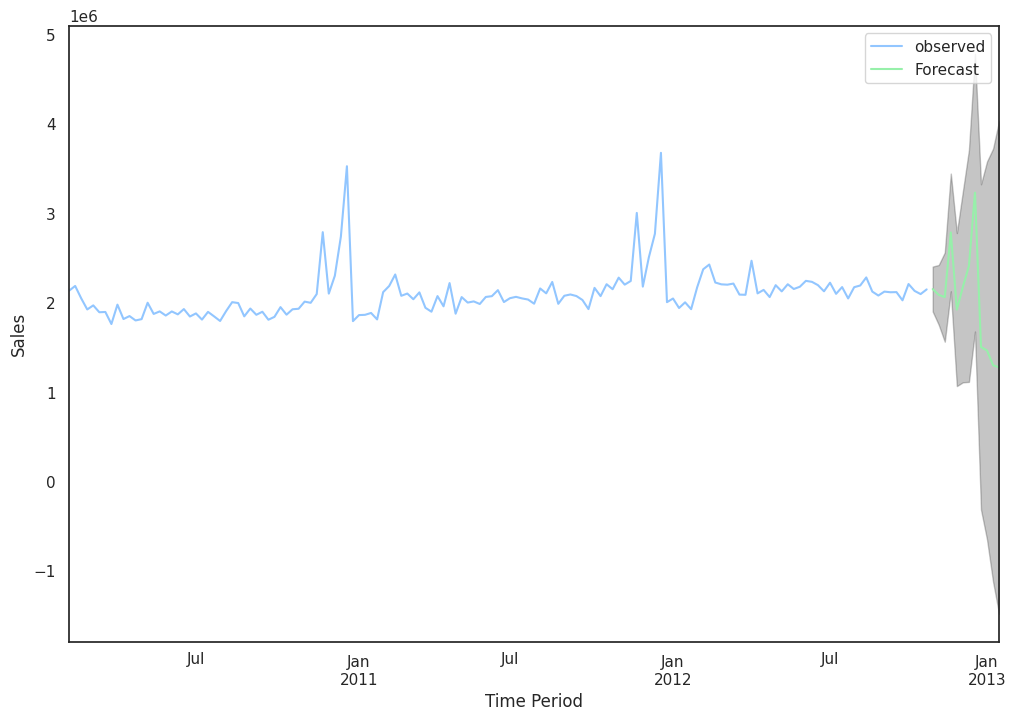

In [57]:
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### For future prediction the model is not that great because the error interval is way big. But if we just check the green line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better and error is also low.


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Modelling & Machine learning</p>

In [58]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis 

In [59]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Statistical analysis and correlations</p>

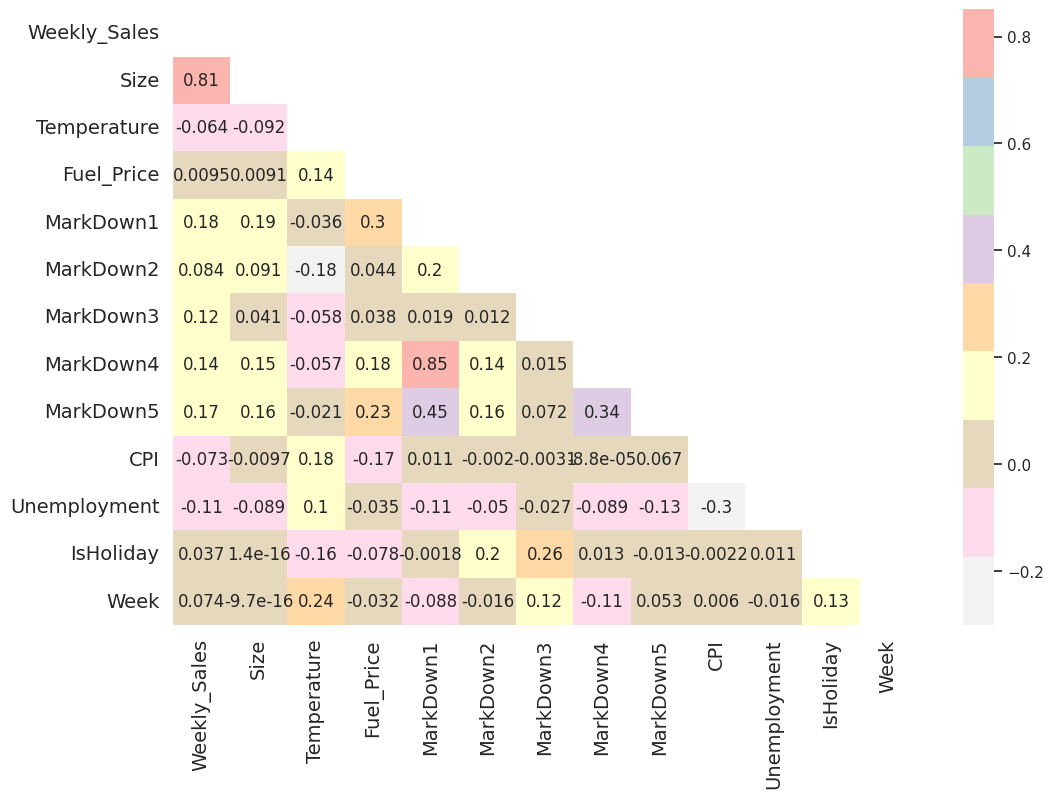

In [60]:
correlation_heat_map(data_heatmap_df)

#inference: By checking the direct correlation of features there is no much promising correlations. 
#           There are no much correlation within the features as well. In a way this is good because 
#           there won't be multicollinearity that we have to take care while running models.



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  Plotting data</p>

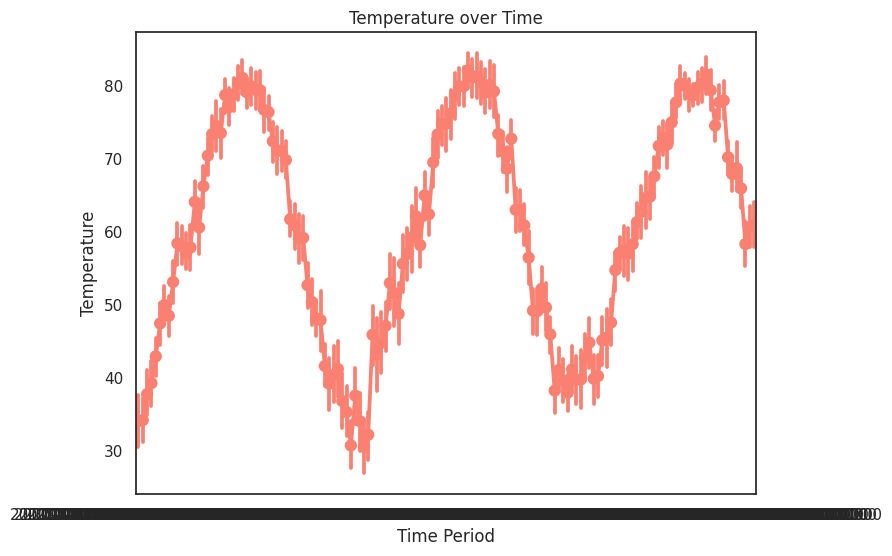

In [61]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
# be an interesting data point that we can use for studies further

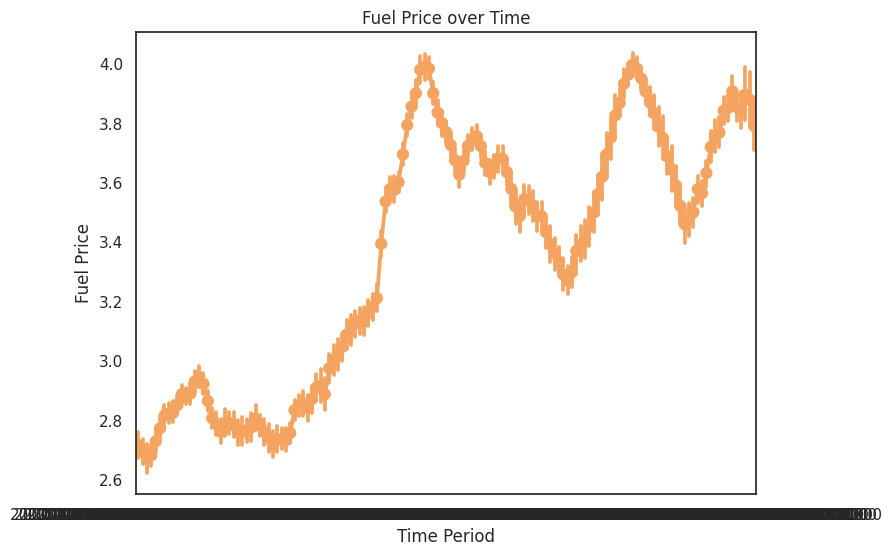

In [62]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows

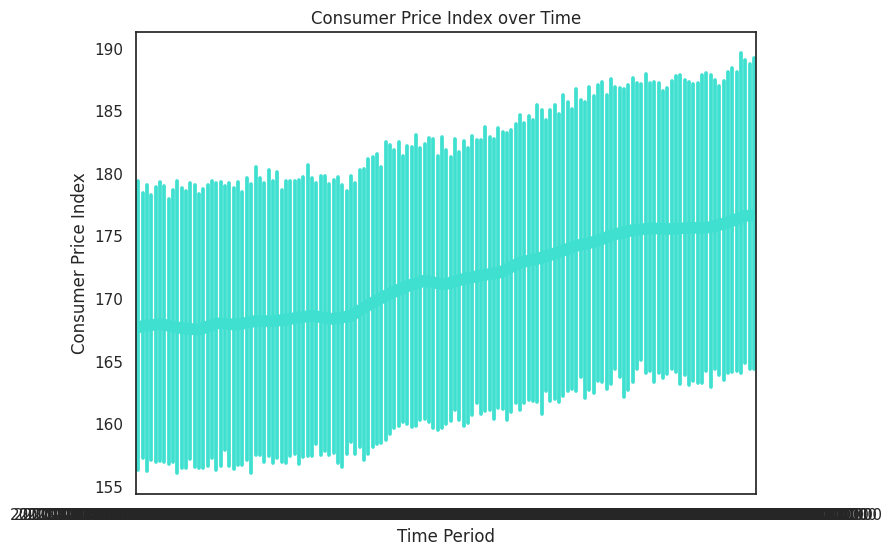

In [63]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much

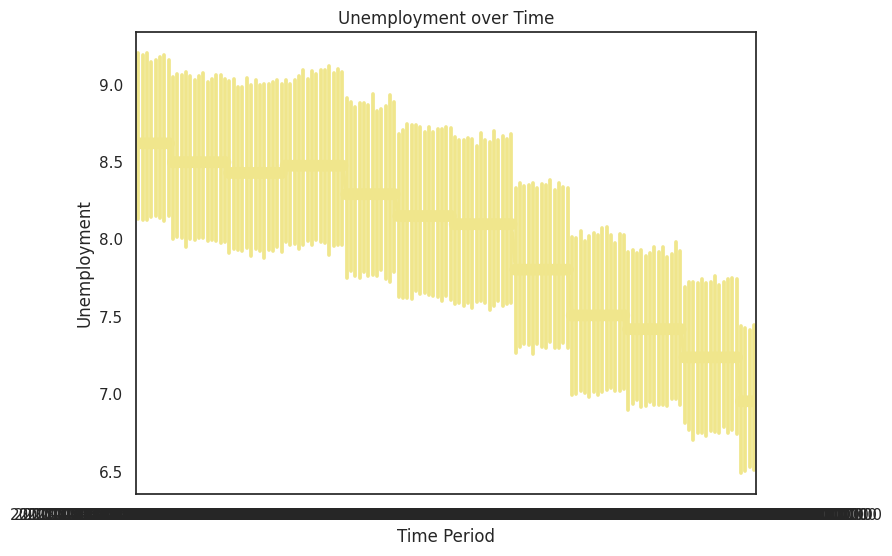

In [64]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales


**This is interesting. Features over time changes quite a bit. We will see whether these have any effects on Sales while we model**

We know that **Markdown columns have quiet few outliers** it can be because of our imputation as well. So we will treate them later and try implement a better way of imputation. Eg: KNN imputation, Random value between min and max imputation..

**Weekly Sales also seem to have some Outliers but we will keep them as it is for now as they may indicate crucial information.**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Visual analysis</p>

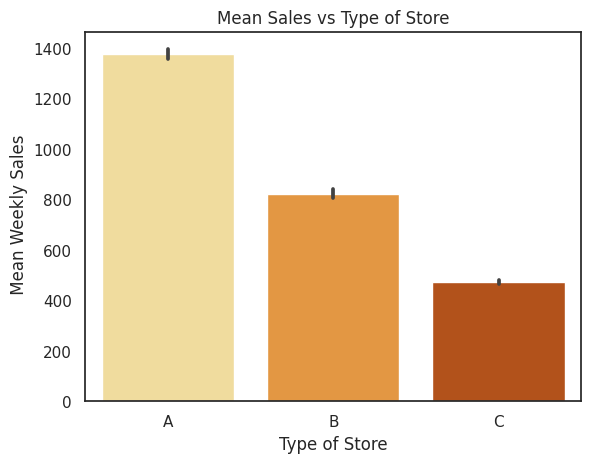

In [65]:
# Checking how the Type of the store have effect on the sales.
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
#plt.savefig('./images/Type_vs_Sales.png')
plt.show()

# inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales. 

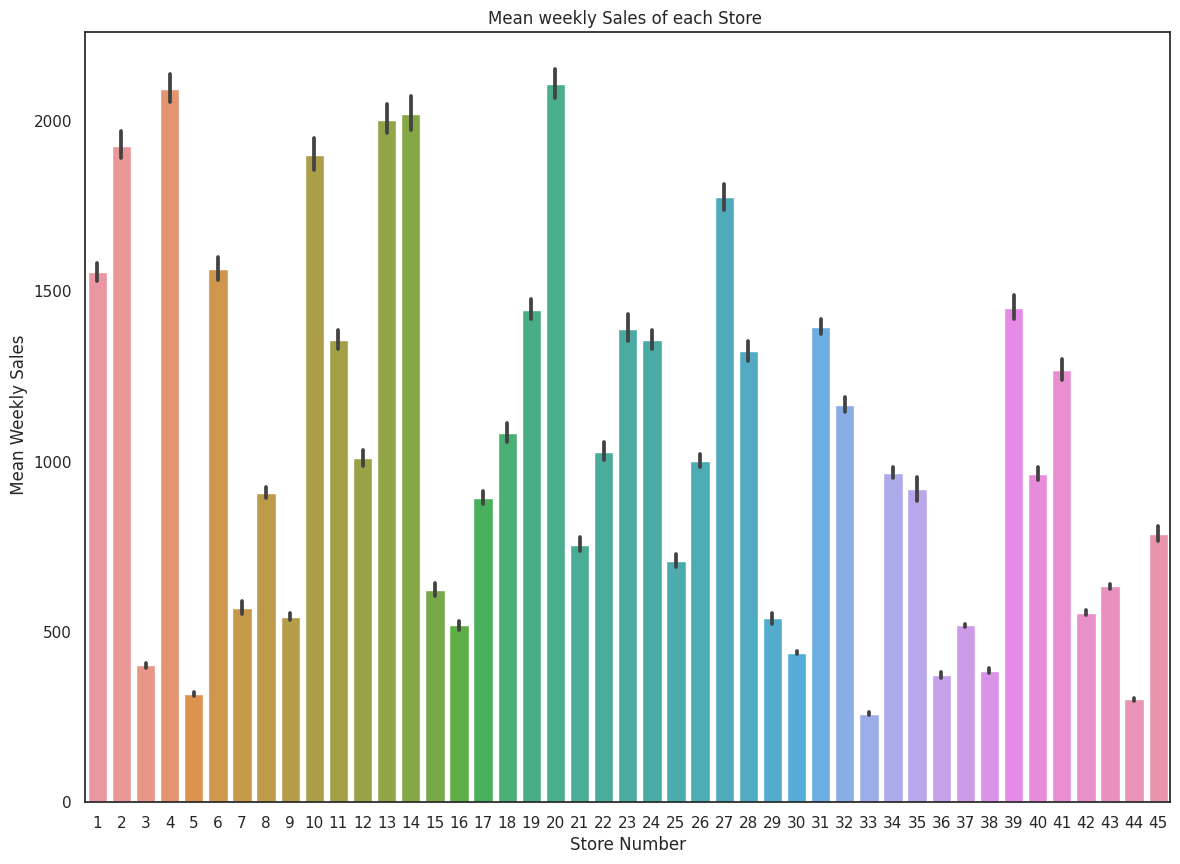

In [66]:
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
#             to $2,200,000

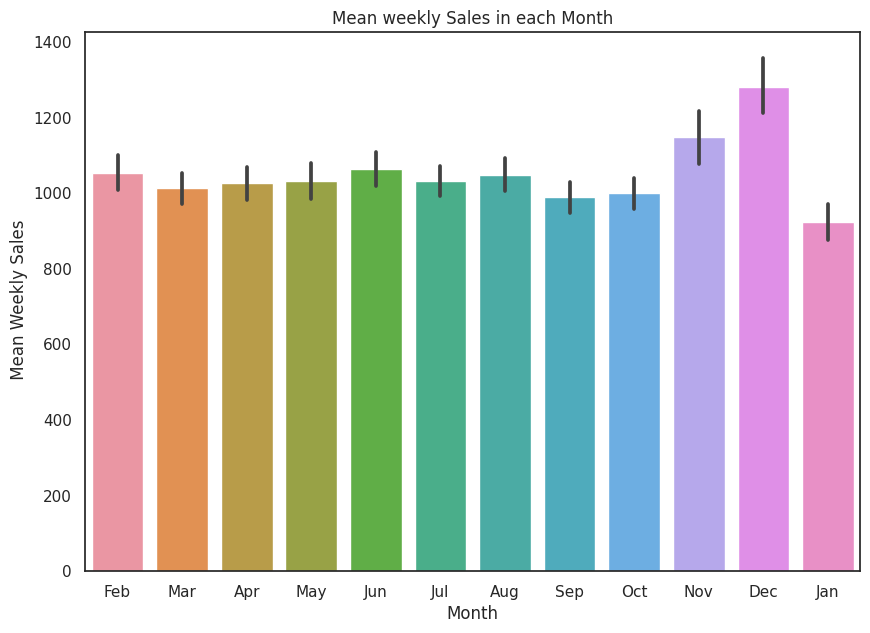

In [67]:
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales 
#            compared to every other month and January have the least sales. 

#### With this we come to an end of EDA & Time series analysis. We will now move forward with Machine Learning & Modelling


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:230%;border-radius:20px 60px;"> Feature Engineering </p>

#### Before creating and running model we will look through the columns and make meaningful columns and create dummies where needed. 

**We need to take special care (KNN Imputation) of Markdown5 which has many outlier and as we know Markdown1-5 which have a lot of missing values.** 

We will create dummies for **"Store, Month, Year"**



In [68]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [69]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [70]:
# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

In [71]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 



Next, we will perform **KNN (K Nearest Neighbours) imputation for Markdown columns**. 

    This might not be a big success but according to current situation that might be the best way so that I can use those variables for modeling and try how this comes out. Other ways are imputing with 0, median value, random value but those will put same value in all missing data and that can be very miss leading or bad way to do it.

**Lets see whether there would be any effect in sales according to the MarkDowns after this**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  KNN model imputation </p>


#### Finally, it's time for treating the Markdown columns

In [72]:
data.iloc[:,5:10].describe().T

# Inference: more than 50% is missing values with (-500) so imputing with KNN might not be a good idea. 
# But what are the other methods? imputing with random values in the range of that particular columns?
# Lets try that first.


,count,mean,std,min,25%,50%,75%,max
MarkDown1,6435.0,2106.175500,6008.334618,-500.0,-500.0,-500.0,2302.300,88646.76
MarkDown2,6435.0,446.067837,4946.234382,-500.0,-500.0,-500.0,0.090,104519.54
MarkDown3,6435.0,88.158396,5306.320800,-500.0,-500.0,-500.0,3.705,141630.61
MarkDown4,6435.0,661.551088,3853.055534,-500.0,-500.0,-500.0,314.320,67474.85
MarkDown5,6435.0,1260.128491,4227.342723,-500.0,-500.0,-500.0,1983.265,108519.28


In [73]:
data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [74]:
missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales. 

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()


In [75]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [76]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

Best R2 value: 0.14140639091506765 
Best k:  25


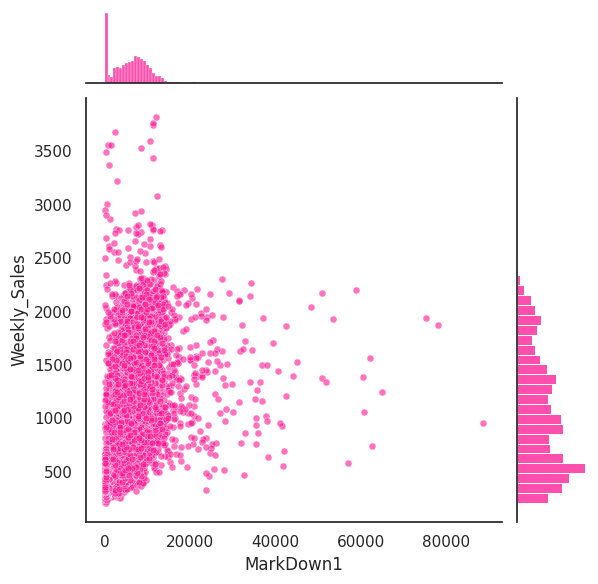

In [77]:
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown1, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color='deeppink')
plt.show()

Best R2 value: 0.41503402148479146 
Best k:  25


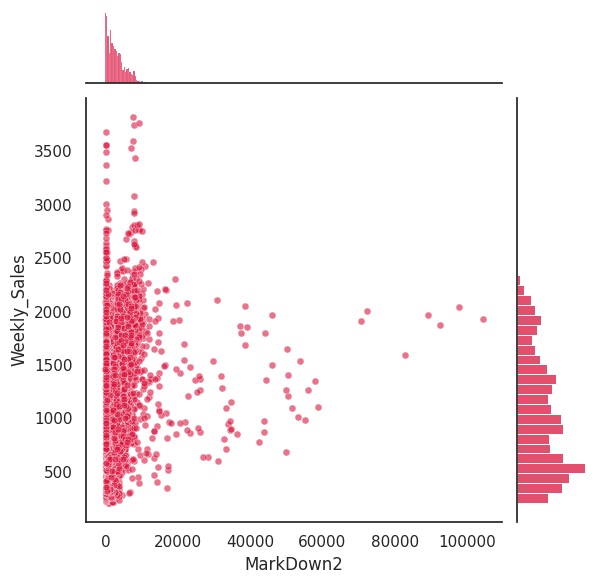

In [78]:
impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown2, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'crimson')
plt.show()

Best R2 value: 0.20431863554303203 
Best k:  25


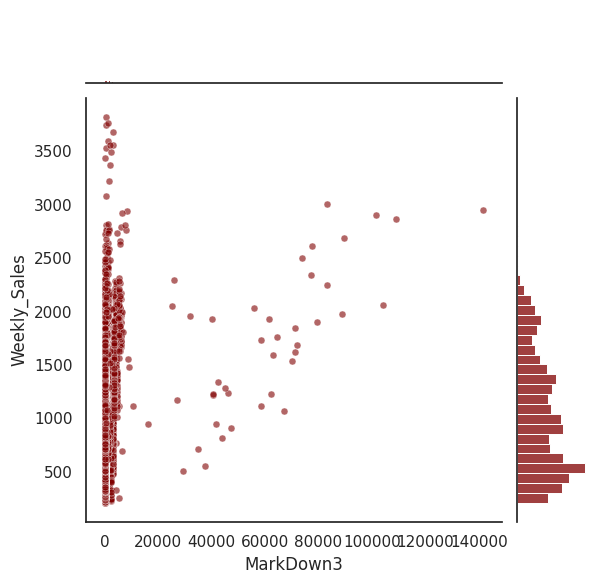

In [79]:
impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute

sns.jointplot(data_imputed.MarkDown3, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color= 'maroon')
plt.show()

Best R2 value: 0.3470822603116795 
Best k:  25


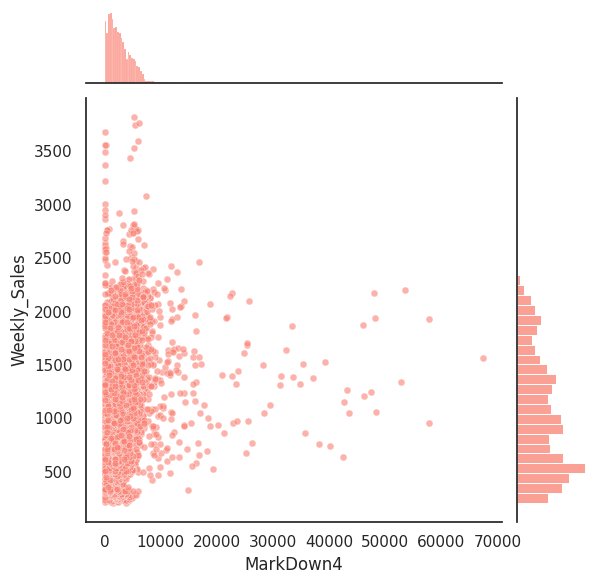

In [80]:
impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'salmon')
plt.show()

Best R2 value: 0.0815206539204145 
Best k:  25


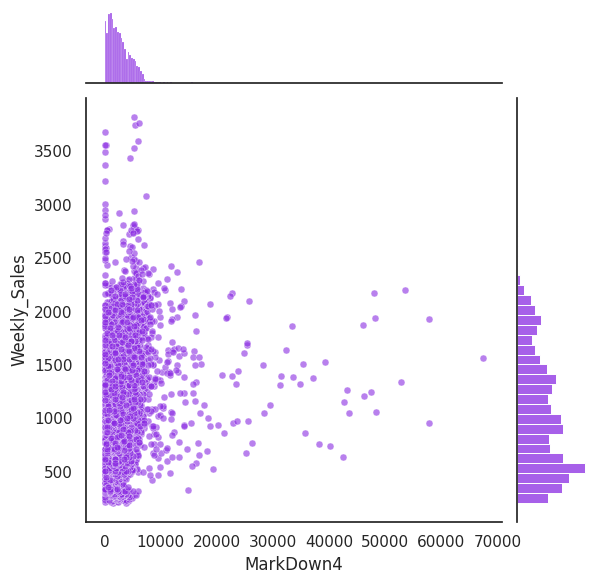

In [81]:
impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'blueviolet')
plt.show()

In [82]:
walmart_data=data_imputed.copy()

# The accuracy and R2 are very bad. This means that we likely imputing crap with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

So finally we have replaced all missing values in **MarkDown1-5** with **KNN imputation** from the given value range itself. We will see the performance of the model and see through whether we have any better methods. As of now my assumption is KNN imputation values would work because thats the best way we have.

**Lets Try Linear Regression for predicting Weekly_Sales with and without the imputed values and see whether its better to keep the imputed MarkDown Values**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;">  Modelling </p>


0.938619735655709
0.9470683005924639
Adjusted R^2 0.9379055627686842
Cross-validated scores: [0.94222507 0.93969413 0.92362047 0.94308012 0.95044027 0.94979278
 0.95857798 0.93433981 0.95177373 0.95831299]
Mean Cross validation 0.9451857355387341


Text(0.5, 1.0, 'Predicted vs Actual Sales')

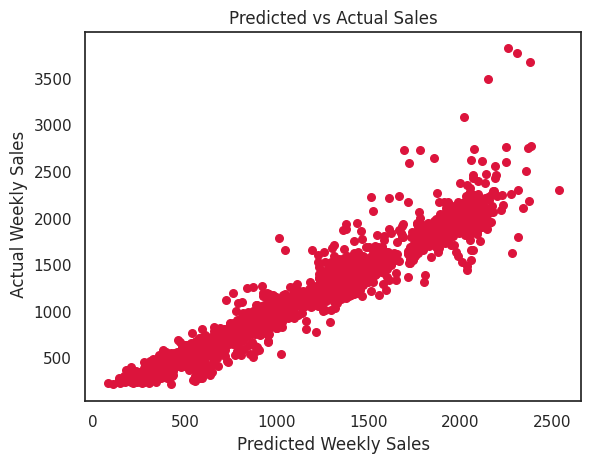

In [83]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

**Now let us look the same model without MarkDowns to check whether data with MarkDown or without MarkDown is good.** 

0.9449407136561558
0.9388616583619209
Cross-validated scores: [ 7.00623668e-01 -1.33870520e+14 -6.84387285e+13 -1.72280102e+13
 -1.23415215e+13 -4.95210879e+13 -4.60945540e+09 -2.18106461e+13
 -2.42618948e+12 -9.55068486e+13]
Mean Cross validation -40114816214137.42


Text(0.5, 1.0, 'Predicted vs Actual Sales')

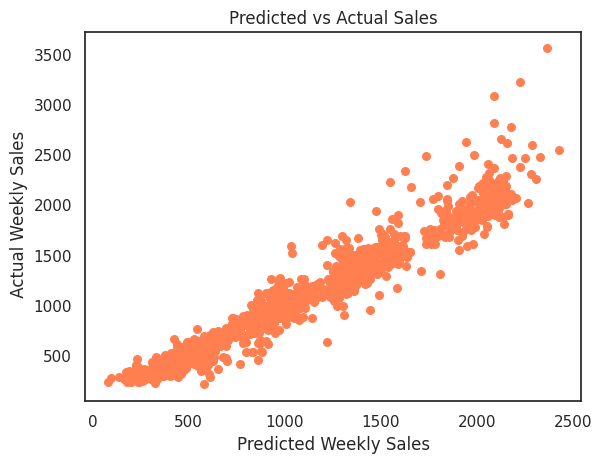

In [84]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

#### From the Cross validation its clear that the one with Markdown values are better than they are dropped. 

So we will keep MarkDowns as of now and **assume** the KNN model have imputed the correct values. 
Now lets move on to real **Modeling** for the prediction of Weekly_sales

We have seen that normal running of Linear regression is a very bad idea. Even though it gives a high R2 value the cross validated score doesn't make any sense. Now its time to go on with **feature selection**


In [85]:
data=data_imputed.copy()

**We will divide our train and test datasets first and then deal with that seperately**

In [86]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset

In [87]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

**Before we start lets shuffle the dataframe a bit because while we use crossvalidation for regressors it won't take a random sample as test and train, instead it takes section by section. Here my Dataframe have data for each store in order. So if we take section by section model might not have enough data to learn about certain stores and which intern will give terrible answers**

In [88]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers

In [89]:
data_train.columns

Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Year_2011', 'Year_2012', 'Week_1.0', 'Week_2.0',
       'Week_3

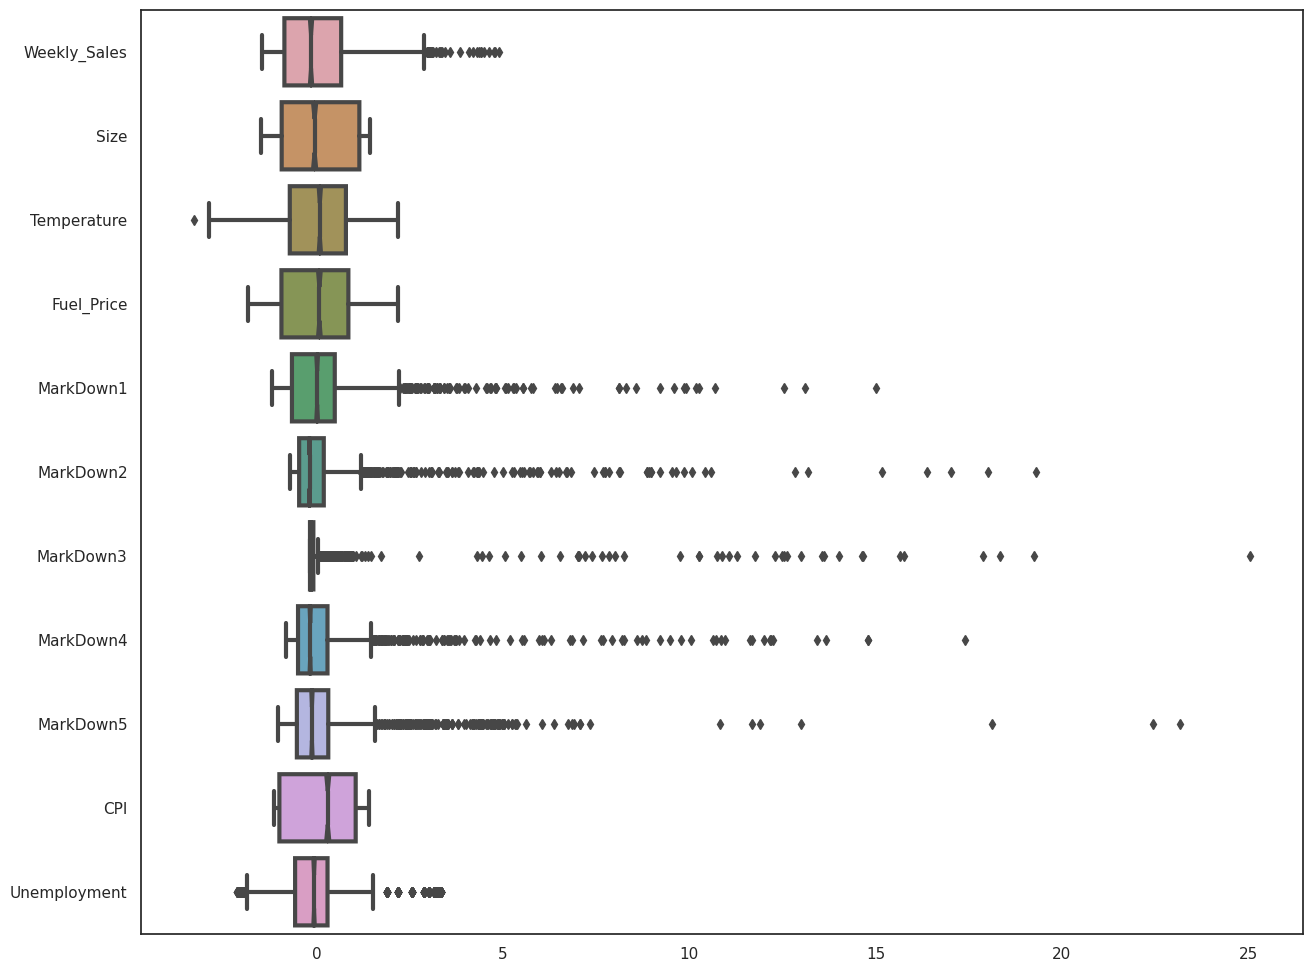

In [90]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

**There are quite a lot of outliers in MarkDown, But Lets first deal the outliers in weekly sales data because we might just drop MarkDowns Later because the percentage of missing values are really high in MarkDowns**

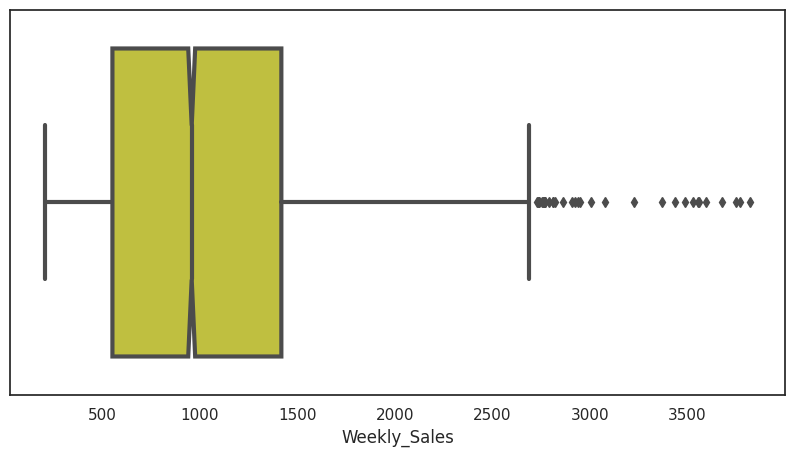

In [91]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [92]:
# Lets consider 3,000,000 as upper limit 
data_train[data_train.Weekly_Sales>3000].shape

(14, 76)

In [93]:
# there is only 14 outliers. Lets drop it and proceed.
data_train=data_train[data_train.Weekly_Sales<3000]

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Improve and Evaluate Model</p>


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Feature Selection </p>


We have seen the models are giving a terrible crossvalidation score. So lets tune our model. for that first we should figure out what all should we use as our features. For this a feature selection would be the best thing. So lets use Lasso Feature Selection and see how our model works with that.

In [94]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Test-Train Split such that Test data is last 90 days data (future 3 months prediction) </p>

In [95]:
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

In [96]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> LGBM Regressor </p>

**LightGBM is a relatively new algorithm. It is a gradient boosting framework that uses tree based learning algorithm.**

*Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.*

It chooses the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. Light GBM is prefixed as ‘Light’ because of its high speed. 

**Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.**

In [97]:
lgbm_features = lgb.LGBMRegressor() 

In [98]:
lgbm_features.fit(X_train, y_train)

LGBMRegressor()

In [99]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

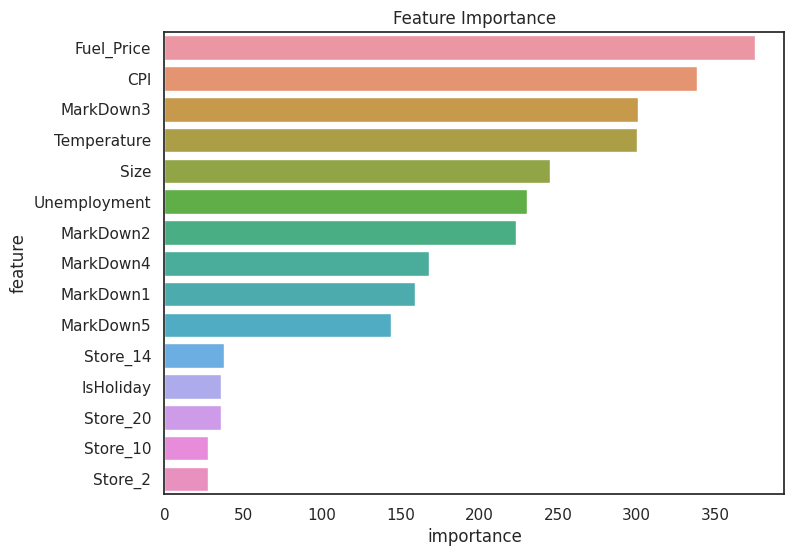

In [100]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');

#### Clearly we have the top features listed above.

**Top five :**
    
    Fuel_Price
    CPI
    Markdown3
    Temperature
    Size
    

## Note :
    
 1. sklearn’s algorithm cheat sheet suggests to try Lasso, ElasticNet, or Ridge when our data-set is smaller than 100k rows. Else, try GDRegressor.

 2. Lasso and ElasticNet tend to give sparse weights (most zeros), because the l1 regularization cares equally about driving down big weights to small weights, or driving small weights to zeros. If you have a lot of predictors (features), and you suspect that not all of them are that important, Lasso and ElasticNet may be really good idea to start with.

***As both the above conditions satisfy, we should go with Lasso regressor and see the performance.***

*If it's not good enough we can always switch back to LGBM/XGB etc.*

#### LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 

*The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.*

**So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.**

Here, we want to evaluate the best model complexity (order of polynomial degree) for our LASSO regression model. Do we need linear regression with 7th degree order terms to reach the best accuracy, or is 2nd degree enough? Let's see.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Lasso Feature Selection </p>

Test- Train Split such that Test data is last 90 days data (Like a furture 3 months prediction)

#### LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 

*The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.*

**So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.**

Here, we want to evaluate the best model complexity (order of polynomial degree) for our LASSO regression model. Do we need linear regression with 7th degree order terms to reach the best accuracy, or is 2nd degree enough? Let's see.

In [101]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [102]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

,feature,coef,abscoef
0,Size,347.440079,347.440079
11,Type_A,172.384215,172.384215
21,Store_10,131.966692,131.966692
19,Store_8,-98.376268,98.376268
51,Store_40,-92.706010,92.706010
43,Store_32,-89.647948,89.647948
44,Store_33,-85.179793,85.179793
20,Store_9,-77.209609,77.209609
52,Store_41,-77.163473,77.163473
45,Store_34,-75.254886,75.254886


In [103]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

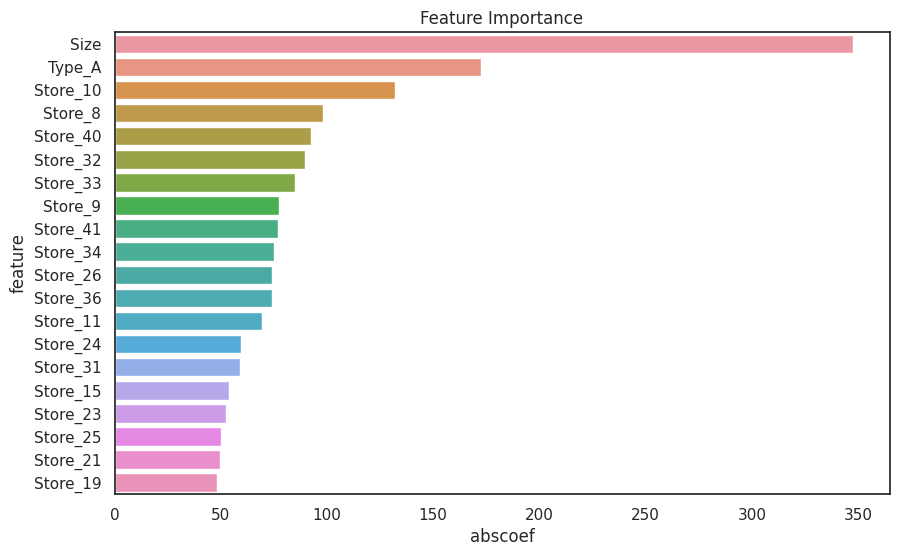

In [104]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lasso_feat.head(20), x='abscoef', y='feature');

**The list of features that are seleted and their magnitude of effect on weekly sales can be seen above (remember the target is scaled down)**

*We will set the predictors that we got from Lasso as our actual predictors and use in further models*

In [105]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [106]:
# Lets see the best alpha score
lasso_cv.alpha_

#best alpha value is 0.45384197291954748 which could be used later to run model

0.4538419729195478

In [107]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=0.4538419729195478)

In [108]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.92458376 0.93628649 0.93373354 0.93343568 0.9354841  0.92348458
 0.94239063 0.93521289 0.93525592 0.93719898]
0.9337066577832152


#### Thats great. getting a cross validated score of .933 is good. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting

In [109]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9602241138737961
Adjusted R2:  0.9559219781827266


In [110]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 500899948.58931684
Test Residual 39751906.32790462
Residual ratio of Test to Train 0.07936097106789052


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size. 


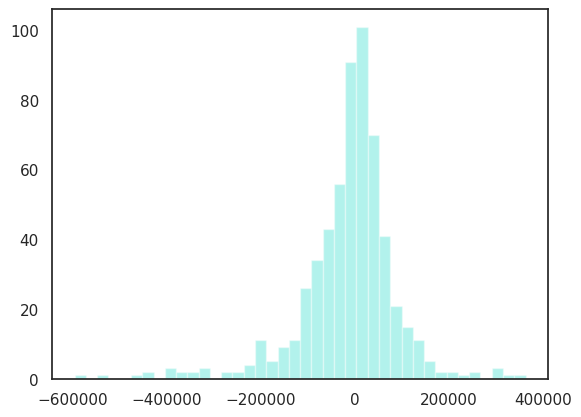

In [111]:
sns.distplot(test_resids, kde=False, bins=40, color = 'turquoise')
plt.show()

# The residuals looks ok and almost like a normal distribution

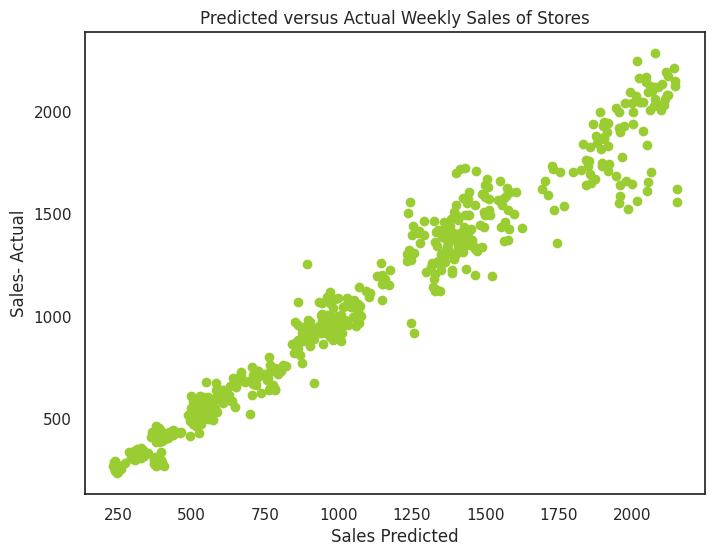

In [112]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
#plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving me a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. **The actual vs Predicted Sales looks promising** 


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Setting the predictors from Lasso and Train Test split for further use </p>

We will set my predictors to the ones that are selected from Lasso and will use this predictors and Train Test split for further use in all my models.

In [113]:
X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)




# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Final Model selection & Implementation</p>


We have already implemented Lasso Regressor and would be looking through and implementing different model of regressors in this part. This is more or a trail and error method with the know models that could do better in Regressions



#### Decision Trees are likely to overfit and result in over learning. 
So we will go for Random Forest Regressor which is a ensemble method of decision tree and check how it works.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Random Forest Regressor </p>

In [114]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')

In [115]:
# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.9496380875047249

In [116]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.782545441202759
Adjusted R2:  0.760840937217347


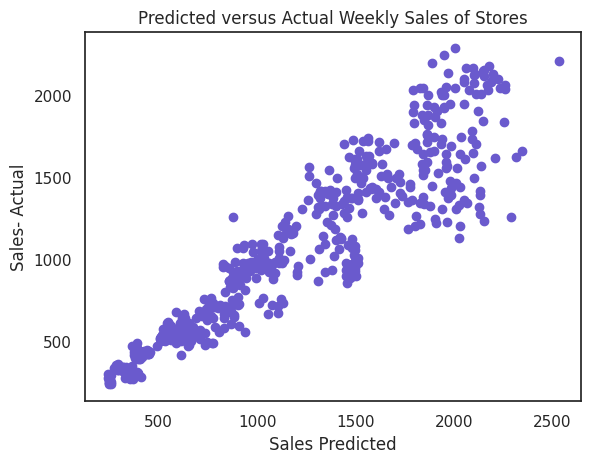

In [117]:
plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [118]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149810851.63059992
Test Residual 93104514.85550003
Residual ratio of Test to Train 0.6214804457895677


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> GradientBoostingRegressor</p>

In [119]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [120]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9505595235623338

In [121]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.7680789004628965
Adjusted R2:  0.7449304667991179


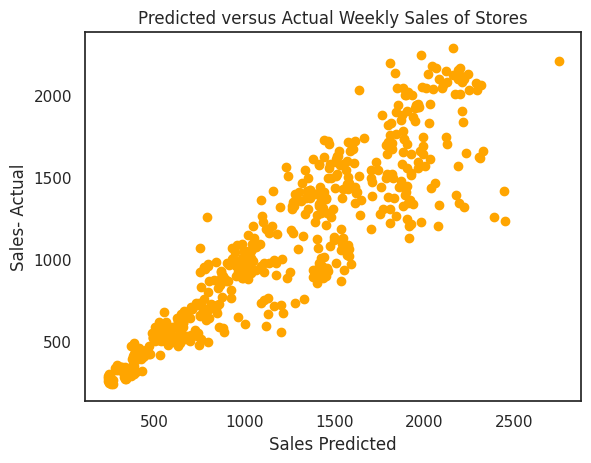

In [122]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [123]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 70612589.50101233
Test Residual 95171332.49059755
Residual ratio of Test to Train 1.3477955299916191


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign.
I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.

**This again is a clear case of over fitting and we wont use this model further.**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Support Vector Regression</p>

In [124]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [125]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.5576476862641006

In [126]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.4046521054266454
Adjusted R2:  0.3452294342168756


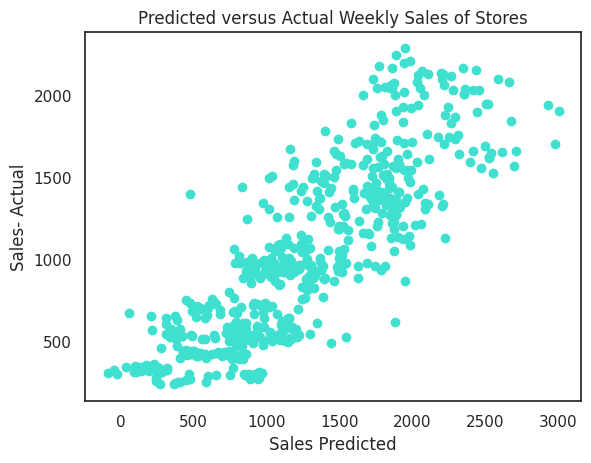

In [127]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [128]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual", np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149810851.63059992
Test Residual 192235311.0814377
Residual ratio of Test to Train 1.283186825180375


**This looks great!** The cross validation score and score on test data are almost same even though its not a very high percentage. Even the residuals are small. This tells atleast there is no much overfittig.

#### So out of all models the best comes with Lasso regression

In [129]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [130]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

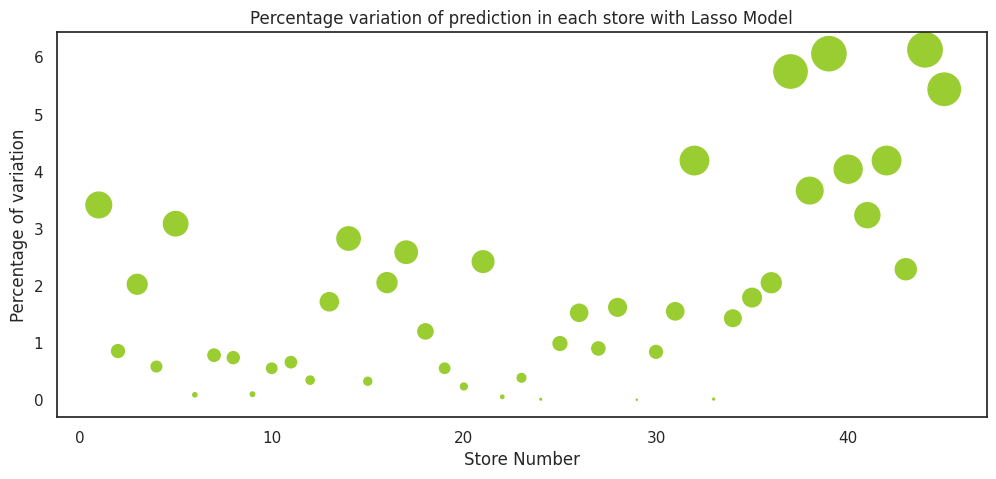

In [131]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
#plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

#### This plot shows the variation of prediction or the percentage residual change for each store.

Here the bigger the bubble is the higher the variation in prediction. So we can see that there are **around 4 stores which have more than 5% variation in prediction.**

**The smaller the bubble the better it is** since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.


In [132]:
# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting','SupportVector')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score,svr_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2,svr_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue,svr_residue)


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Insights & Conclusion</p>

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Interpret findings and relate to goals/criteria</p>


 - From the modeling we have found **Lasso method works the best by itself with an accuracy of .93.**

 - The **rain forest regressor and SVR also works good**. We have plotted a percentage residual change with bubbles to check how good is the prediction for each store. 
 
 - This could be a good method to look into each store and see which stores are doing good with this model and which are not. 
 
 - Similarly we can find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

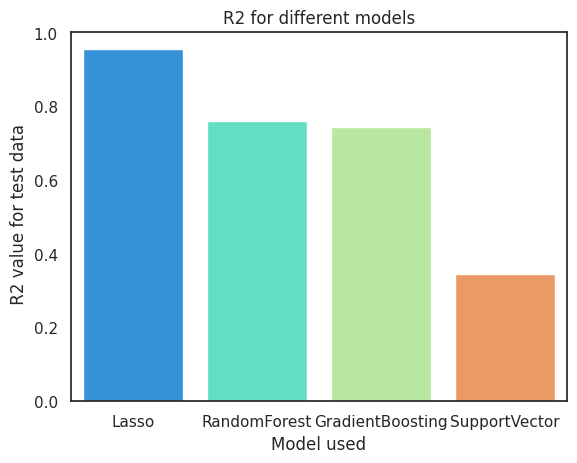

In [133]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()


**Lasso Regressor gives the best prediction and outperforms all other models as indicated by the R2 values.**

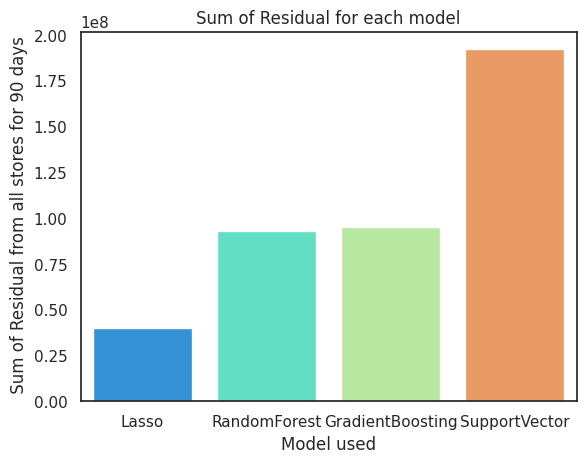

In [134]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual from all stores for 90 days')
plt.title('Sum of Residual for each model')
#plt.savefig('./images/Residual_for_different_models.png')
plt.show()

**Even the residual for Lasso model is way smaller compared to other models**

### Conclusion

*Finally, after building multiple models to predict the weekly sales of 45 stores, we got the best accuracy of around 94% of accuracy for 3 months(90 Days).*

Out of all the models, we select the **Lasso Regressor as our predictive Model since due to it's highest prediction accuracy  with the lowest residual(error).**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Recommendation and Benefits</p>

1. **Size of the store is the highest contributing predictor in the model out of all.**
2. **Each store has a unique prediction power**. They can be separately analyzed to get prediction for each individual store
3. The **Sales are very high during November and December and go down in January**. So its better to employee more staff as casual employee in November and December and encourage permanent staff to take leaves during January.
4. The predicted sales data can be used to analyse the sales pattern and accordingly **adjust the staff in the store.**
5. When we implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which will further help in **better planning and cost cutting** for **inventory management, supply chain management and human resource.**
6. The **low selling stores should look forward to increasing their size and capacity to store more items and consumer products.**
7. **Special discount coupons can be distributed during low selling periods to attract more customers**

8. Sales are likely to fluctuate during holidays. **Special offers can be given during festive season** accompanied with suitable marketing to keep the sales high during holidays as well


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Next steps</p>

**The Next steps would be :-**

1. To check into the store that have poor prediction and check deep what makes those bad. 
2. To further improve the predictive model using the ensembling method to combine models and come with better model.
3. Take the data to Department level and to predict the Department level sales which would help to solve the inventory management issues and supply chain management.

![](https://businessfirstfamily.com/wp-content/uploads/2016/01/sales-forecasting-methods-graphs.jpg)

# <p style="background-color:white;font-family:newtimeroman;color:turquoise;font-size:150%;text-align:center;border-radius:20px 60px;">REFERENCES</p>

https://medium.datadriveninvestor.com/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

https://prezi.com/vpvakz73fjjp/walmart-sales-analysis/

https://www.kaggle.com/code/maxdiazbattan/wallmart-sales-eda-feat-eng-future-update

https://www.kaggle.com/code/avelinocaio/walmart-store-sales-forecasting

https://www.kaggle.com/code/yepp2411/walmart-prediction-1-eda-with-time-and-space

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">HAPPY FORECASTING!!!</p>